# Project 1: Linear Quadratic Regulator (LQR) Design
>**Date Created**: 26 January 2024<br>
>**Course**: AEM566 - Optimal Estimation<br>
>**Author**: Benjamin Lucke<br>

In [1]:
import control as ct
import numpy as np
import pandas as pd
import scipy as sp
import sympy as smp

from numpy import sin, cos
from matplotlib import pyplot as plt

___

## Problem 1

Compute the eigenvalues of the state matrix for the continuous LTI system and comment on the stability of the system.

In [2]:
mu = 3.986004418 * 10**14
rt = 6783000
x0 = np.array([1000, 1000, 1000, 0, 0, 0])
P0 = np.zeros((6, 6))
nt = np.sqrt(mu / (rt**3))
ti = 0
tf = 16200
n = 25000
t_eval = np.linspace(ti, tf, n)

In [3]:
A_ct_numpy = np.array(
    [
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [3 * nt**2, 0, 0, 0, 2 * nt, 0],
        [0, 0, 0, -2 * nt**2, 0, 0],
        [0, 0, -(nt**2), 0, 0, 0],
    ]
)
B_ct_numpy = np.array(
    [[0, 0, 0], [0, 0, 0], [0, 0, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1]]
)
e = np.linalg.eig(A_ct_numpy)

**Problem Response**

> $r_t$ will never be less than zero, and $\mu$ is a constant greter than zero, so $n_t$ will always be greater than zero. For $n_t \geq 0.75$, the eigenvalues of the dynamics matrix are purely imaginary and thus the system is **marginally stable**, that is, the system will have bounded oscillations with no control input. 

## Problem 2
Compute the controllability matrix for the continuous-time LTI system.

In [4]:
ctrb = ct.ctrb(A_ct_numpy, B_ct_numpy)
print(np.linalg.matrix_rank(ctrb))

6


**Problem Response**

> System is controllable since the controllability matrix is full rank.

## Problem 3

Design a finite-horizon LQR for the continuous time system with $t_f = 16200 s$ using ODE solvers.

In [5]:
def Pdot_continuous(t, P, A, B, Q, R):
    P = P.reshape(6, 6)
    pdot = -P @ A - A.T @ P + P @ B @ np.linalg.inv(R) @ B.T @ P - Q
    return pdot.flatten()


def xdot_continuous(t, x, Ps, A, B, R, t_interp):
    interpolator = sp.interpolate.interp1d(t_interp, Ps.reshape(36, -1))
    P = interpolator(t).reshape(6, 6)
    K = np.linalg.inv(R) @ B.T @ P
    xdot = (A - B @ K) @ x
    return xdot


def calculate_u_continuous(t_eval, A, B, R, Ps, x0):
    us = np.zeros((3, max(t_eval.shape)))
    xs = np.zeros((6, max(t_eval.shape)))
    interpolator = sp.interpolate.interp1d(t_interp, Ps.reshape(36, -1))
    for k, t in enumerate(t_eval):
        if k == 0:
            x = x0
            xs[:, k] = x
            continue
        else:
            P = interpolator(t).reshape(6, 6)
            K = np.linalg.inv(R) @ B.T @ P
            u = -K @ x
            xdot = A @ x + B @ u
            x = xdot + x
            us[:, k] = u
            xs[:, k] = x
    return us


def calc_u(Ps, A, R, B, t_solve):
    u_s = np.zeros((3, t_solve.shape[0]))
    interp_P = sp.interpolate.interp1d(t_solve, Ps.reshape(36, -1))
    for k, t in enumerate(t_solve):
        if k == 0:
            x = np.array([1000, 1000, 1000, 0, 0, 0])
        else:
            x = x_c
        P_t = interp_P(t).reshape((6, 6))
        K_t = np.linalg.inv(R) @ B.T @ P_t
        u = -K_t @ x
        x = A @ x + B @ u
        x_c = x
        u_s[:, k] = u
    return u_s

**NOTE: Each of the following 3 cells takes about a minute to run on a decent (Ryzen 5 5600x, 16GB DDR4) PC.**

In [6]:
# Case 1
Q = np.eye(6)
R = np.eye(3)
ARE_case1_continuous = sp.integrate.solve_ivp(
    fun=Pdot_continuous,
    t_span=[16200, 0],
    t_eval=np.linspace(16200, 0, 5000),
    y0=P0.flatten(),
    args=(A_ct_numpy, B_ct_numpy, Q, R),
)
P_case1_continuous = np.flip(ARE_case1_continuous.y.reshape((6, 6, -1)))
t_interp = np.flip(ARE_case1_continuous.t)
closedLoop_case1_continuous = sp.integrate.solve_ivp(
    fun=xdot_continuous,
    t_span=[0, 16200],
    t_eval=np.linspace(0, 16200, 5000),
    y0=x0,
    args=(P_case1_continuous, A_ct_numpy, B_ct_numpy, R, t_interp),
)
u_case1_continuous = calculate_u_continuous(
    t_interp, A_ct_numpy, B_ct_numpy, R, P_case1_continuous, x0
)

In [7]:
# Case 2
Q = np.eye(6)
R = 100 * np.eye(3)
ARE_case2_continuous = sp.integrate.solve_ivp(
    fun=Pdot_continuous,
    t_span=[16200, 0],
    t_eval=np.linspace(16200, 0, 5000),
    y0=P0.flatten(),
    args=(A_ct_numpy, B_ct_numpy, Q, R),
)
P_case2_continuous = np.flip(ARE_case2_continuous.y.reshape((6, 6, -1)))
t_interp = np.flip(ARE_case2_continuous.t)
closedLoop_case2_continuous = sp.integrate.solve_ivp(
    fun=xdot_continuous,
    t_span=[0, 16200],
    t_eval=np.linspace(0, 16200, 5000),
    y0=x0,
    args=(P_case2_continuous, A_ct_numpy, B_ct_numpy, R, t_interp),
)
u_case2_continuous = calculate_u_continuous(
    t_interp, A_ct_numpy, B_ct_numpy, R, P_case2_continuous, x0
)

In [8]:
# Case 3
Q = np.eye(6)
R = 10000 * np.eye(3)
ARE_case3_continuous = sp.integrate.solve_ivp(
    fun=Pdot_continuous,
    t_span=[16200, 0],
    t_eval=np.linspace(16200, 0, 5000),
    y0=P0.flatten(),
    args=(A_ct_numpy, B_ct_numpy, Q, R),
)
P_case3_continuous = np.flip(ARE_case3_continuous.y.reshape((6, 6, -1)))
t_interp = np.flip(ARE_case3_continuous.t)
closedLoop_case3_continuous = sp.integrate.solve_ivp(
    fun=xdot_continuous,
    t_span=[0, 16200],
    t_eval=np.linspace(0, 16200, 5000),
    y0=x0,
    args=(P_case3_continuous, A_ct_numpy, B_ct_numpy, R, t_interp),
)
u_case3_continuous = calculate_u_continuous(
    t_interp, A_ct_numpy, B_ct_numpy, R, P_case3_continuous, x0
)

(0.0, 60.0)

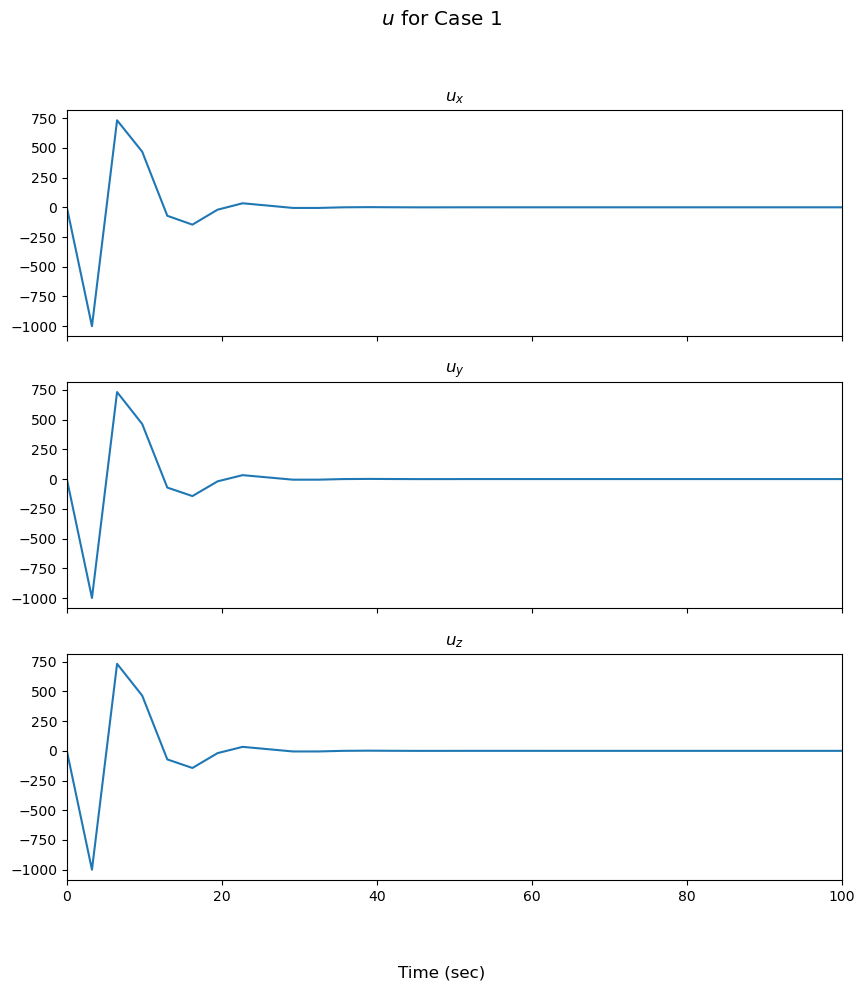

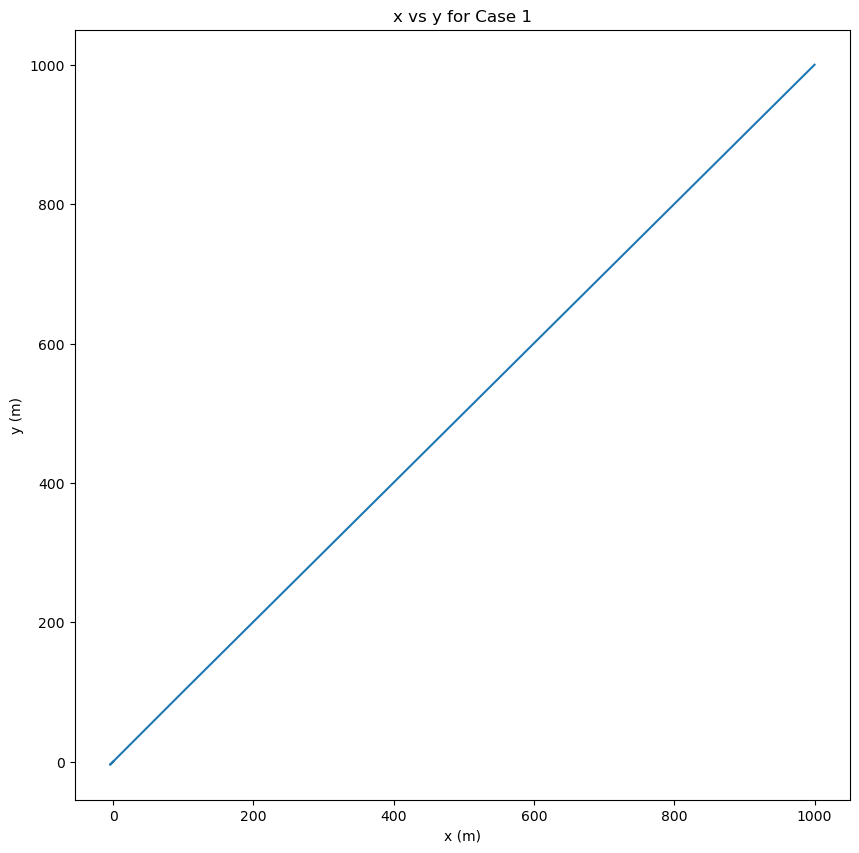

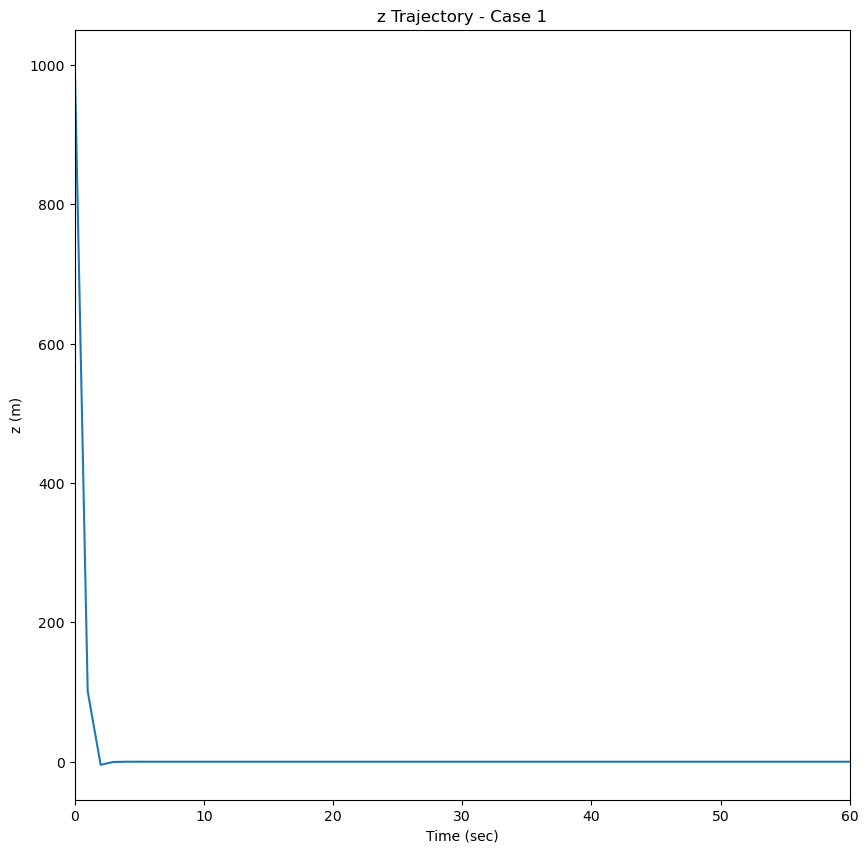

In [9]:
# Plots - Case 1
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10), sharex=True)
fig.suptitle("$u$ for Case 1", fontsize="x-large")
for k in range(3):
    axes[k].plot(t_interp, u_case1_continuous[k, :])
    axes[k].set_xlim([0, 100])
    if k == 0:
        axes[k].set_title("$u_x$")
    if k == 1:
        axes[k].set_title("$u_y$")
    if k == 2:
        axes[k].set_title("$u_z$")
fig.supxlabel("Time (sec)")

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(closedLoop_case1_continuous.y[0, :], closedLoop_case1_continuous.y[1, :])
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_title("x vs y for Case 1")

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(closedLoop_case1_continuous.y[2, :])
ax.set_xlabel("Time (sec)")
ax.set_ylabel("z (m)")
ax.set_title("z Trajectory - Case 1")
ax.set_xlim([0, 60])

(0.0, 100.0)

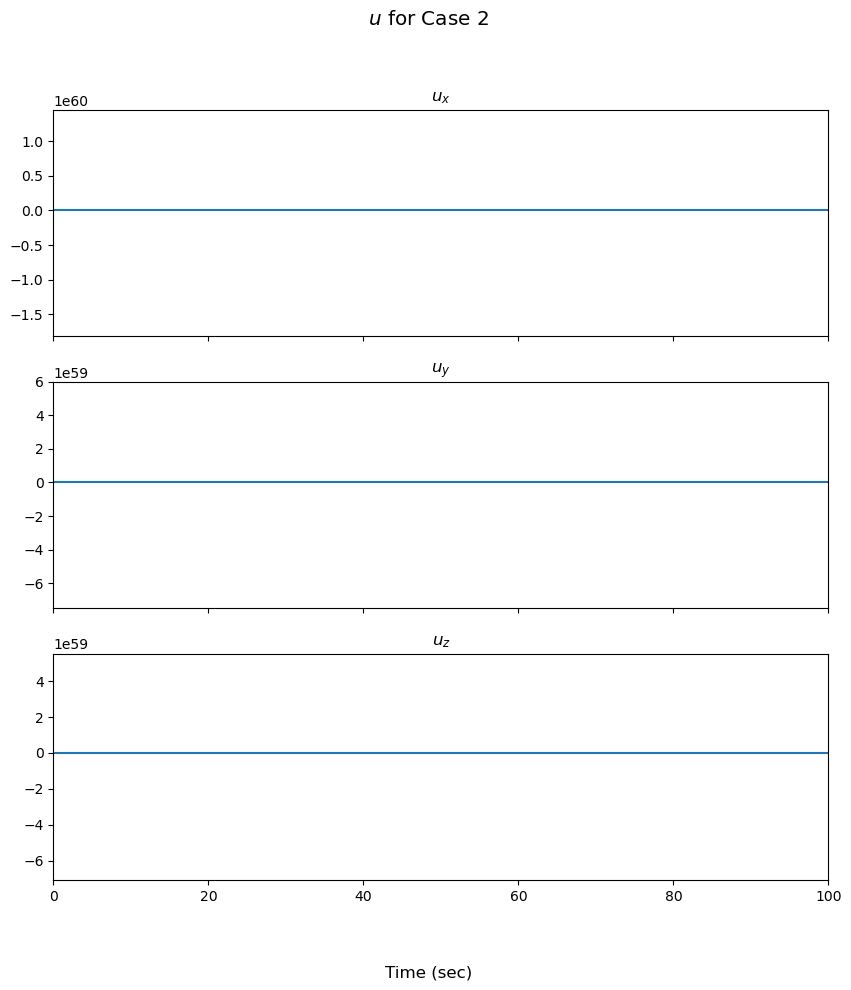

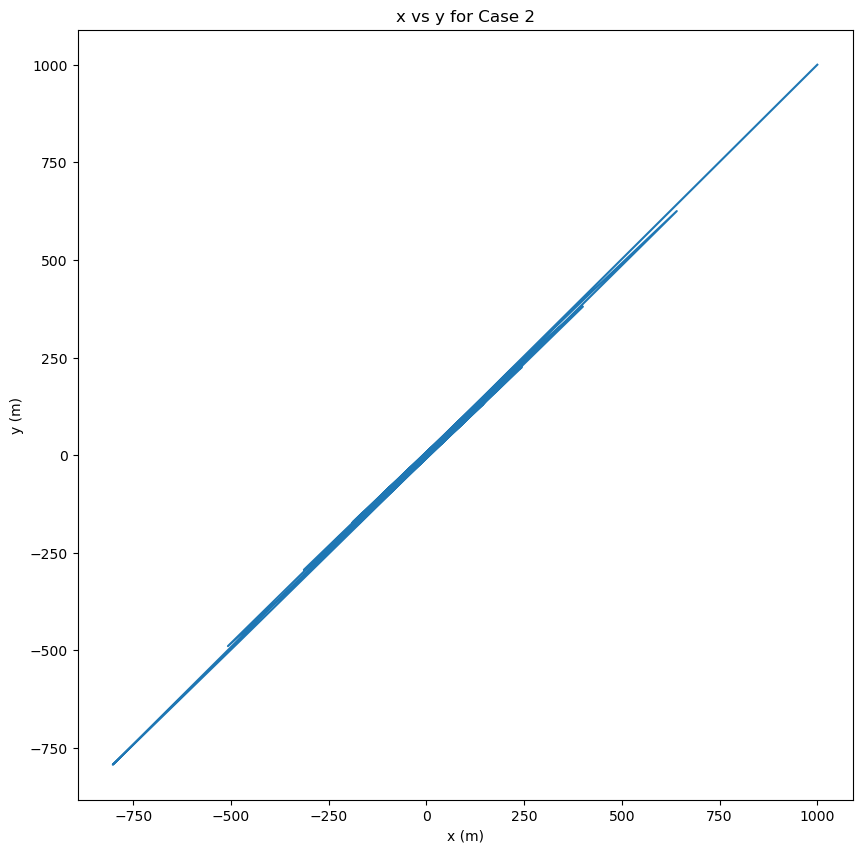

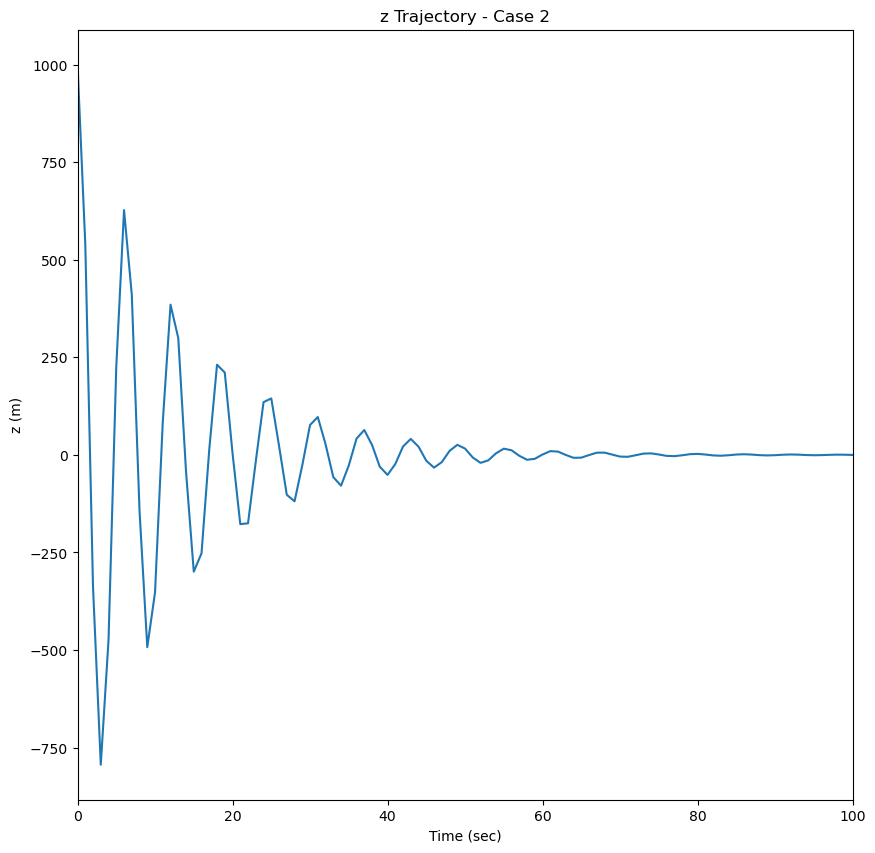

In [10]:
# Plots - Case 2
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10), sharex=True)
fig.suptitle("$u$ for Case 2", fontsize="x-large")
for k in range(3):
    axes[k].plot(t_interp, u_case2_continuous[k, :])
    axes[k].set_xlim([0, 100])
    if k == 0:
        axes[k].set_title("$u_x$")
    if k == 1:
        axes[k].set_title("$u_y$")
    if k == 2:
        axes[k].set_title("$u_z$")
fig.supxlabel("Time (sec)")

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(closedLoop_case2_continuous.y[0, :], closedLoop_case2_continuous.y[1, :])
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_title("x vs y for Case 2")

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(closedLoop_case2_continuous.y[2, :])
ax.set_xlabel("Time (sec)")
ax.set_ylabel("z (m)")
ax.set_title("z Trajectory - Case 2")
ax.set_xlim([0, 100])

(0.0, 1600.0)

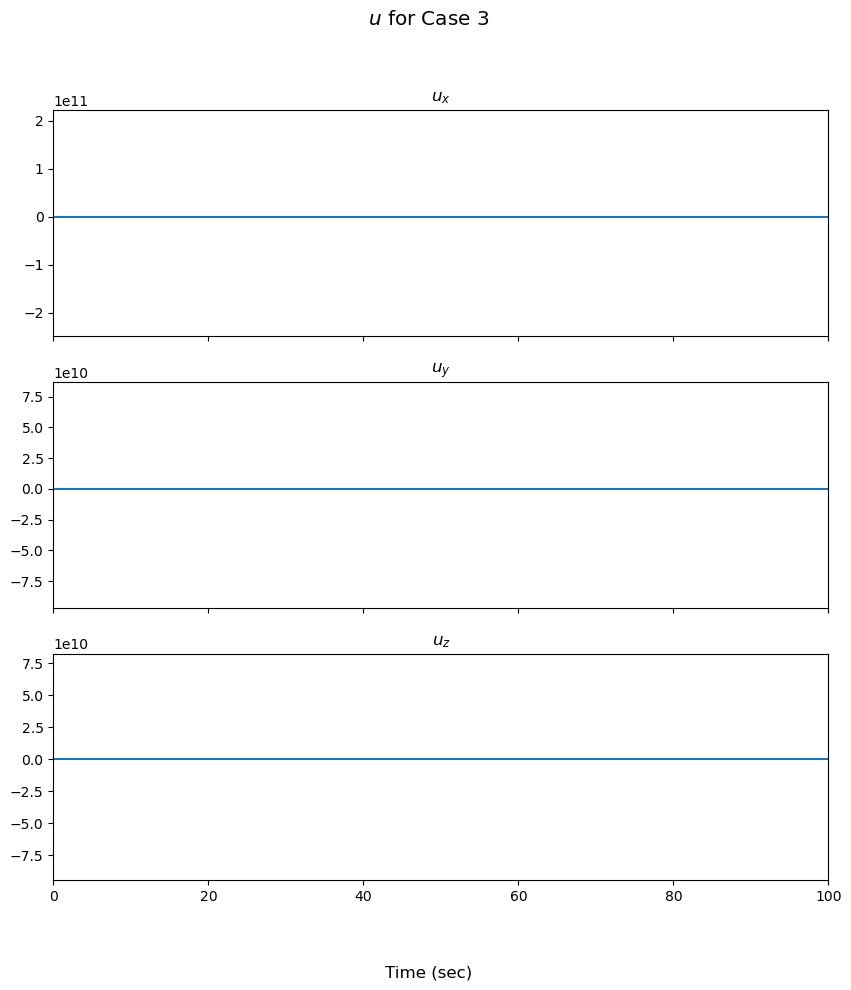

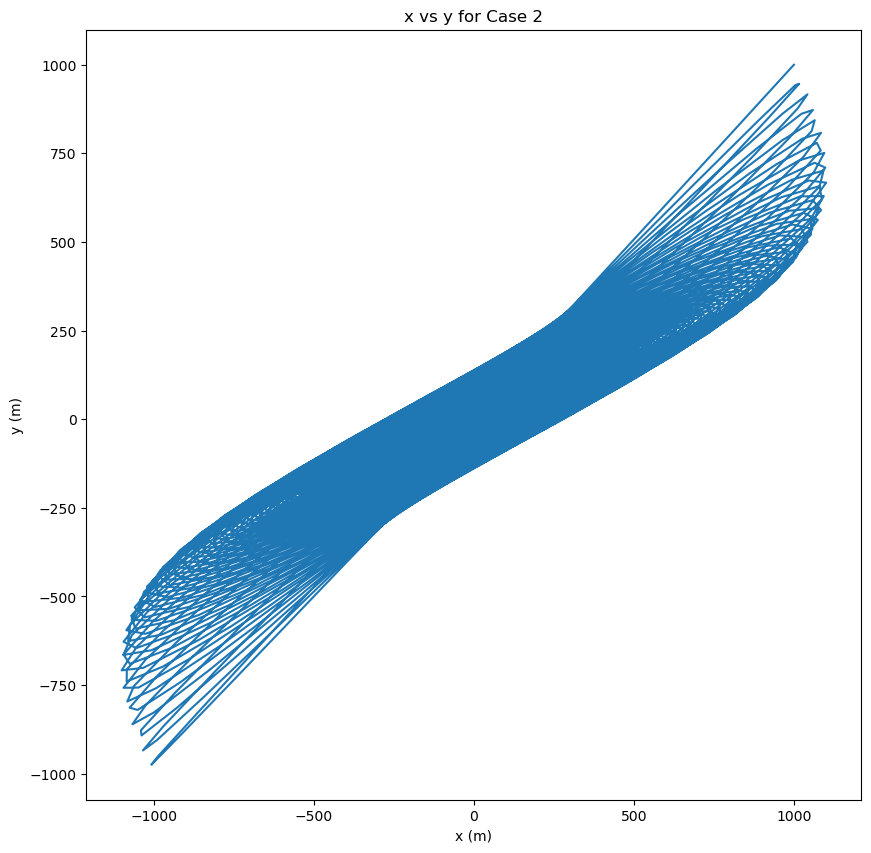

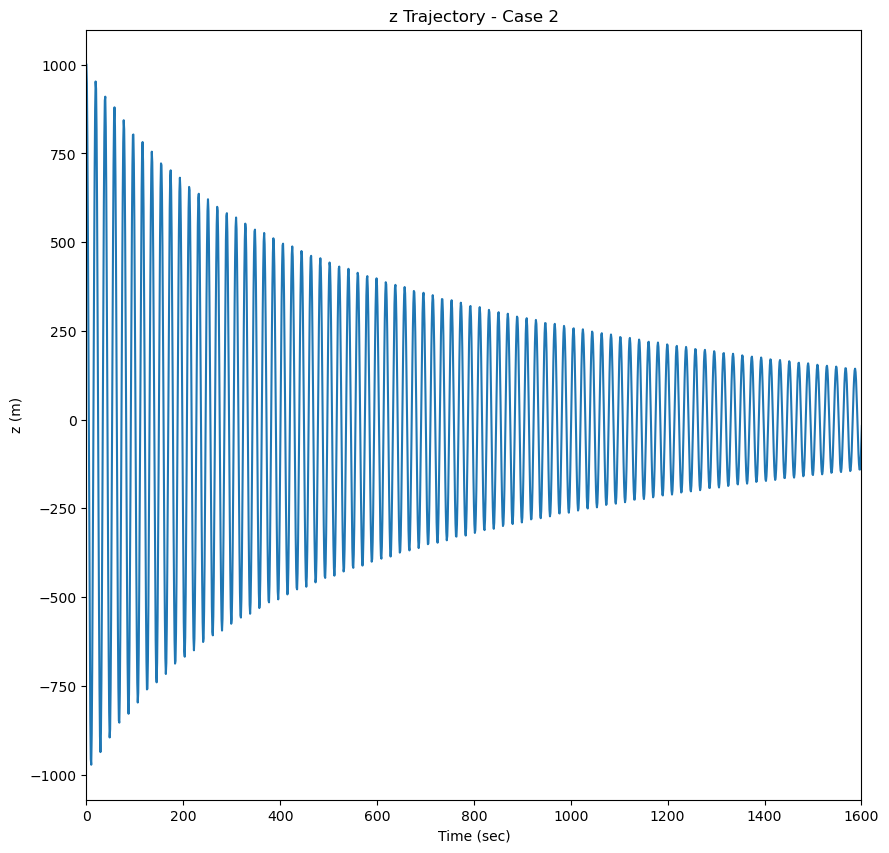

In [11]:
# Plots - Case 3
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10), sharex=True)
fig.suptitle("$u$ for Case 3", fontsize="x-large")
for k in range(3):
    axes[k].plot(t_interp, u_case3_continuous[k, :])
    axes[k].set_xlim([0, 100])
    if k == 0:
        axes[k].set_title("$u_x$")
    if k == 1:
        axes[k].set_title("$u_y$")
    if k == 2:
        axes[k].set_title("$u_z$")
fig.supxlabel("Time (sec)")

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(closedLoop_case3_continuous.y[0, :], closedLoop_case3_continuous.y[1, :])
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_title("x vs y for Case 2")

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(closedLoop_case3_continuous.y[2, :])
ax.set_xlabel("Time (sec)")
ax.set_ylabel("z (m)")
ax.set_title("z Trajectory - Case 2")
ax.set_xlim([0, 1600])

### Problem 4

Design a finite-horizon LQR for the continuous time system with $t_f = 16200 s$ using a continuous-time algebraic Riccati equation solver.

In [12]:
A = np.array(
    [
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [3 * nt**2, 0, 0, 0, 2 * nt, 0],
        [0, 0, 0, -2 * nt, 0, 0],
        [0, 0, -(nt**2), 0, 0, 0],
    ]
)
B = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1]])

In [13]:
def dxdt_care(t, x, A, B, P, R):
    K_t = np.linalg.inv(R) @ B.T @ P
    xdot = (A - B @ K_t) @ x
    return xdot


def calc_u_care(t_eval, A, B, R, P):
    u_s = np.zeros((3, t_eval.shape[0]))  # array to hold output commands, u
    K_t = np.linalg.inv(R) @ B.T @ P  # Optimal gain calculation

    # Compute dynamics and optimal control input, u at each value of t in the series
    for k, t in enumerate(t_eval):
        if k == 0:
            x = x0
        else:
            x = x_c
        u = -K_t @ x
        u_s[:, k] = u
        xdot = A @ x + B @ u
        x = x + xdot
        x_c = x
    return u_s


def plot_u(u_s, title="Case 1"):
    fig, (ax1, ax2, ax3) = plt.subplots(
        nrows=3, ncols=1, figsize=(10, 10), sharex=True, sharey=True
    )
    ax1.plot(t_eval, u_s[0, :])
    ax1.set_xlim([0, 100])
    ax1.set_title("$u_x$")
    ax2.plot(t_eval, u_s[1, :])
    ax2.set_xlim([0, 100])
    ax2.set_title("$u_y$")
    ax3.plot(t_eval, u_s[2, :])
    ax3.set_xlim([0, 100])
    ax3.set_title("$u_z$")
    fig.supxlabel("Time (sec)")
    fig.supylabel("Commanded Acceleration ($m/s^2$)")
    fig.suptitle(title, fontsize="x-large")


def plot_xy(sols, title="Case 1"):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(sols.y[0, :], sols.y[1, :])
    ax.set_title(title, fontsize="x-large")
    ax.set_xlabel("x (meters)")
    ax.set_ylabel("y (meters)")


def plot_z(t_eval, sols, title="Case 1"):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(t_eval, sols.y[2, :])
    ax.set_title(title, fontsize="x-large")
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("z (meters)")
    ax.set_xlim([0, 100])

In [14]:
# Case 1
Q = np.eye(6)
R = np.eye(3)
P_case1_care = sp.linalg.solve_continuous_are(A_ct_numpy, B_ct_numpy, Q, R)
sol_case1_care = sp.integrate.solve_ivp(
    fun=dxdt_care, t_span=[ti, tf], t_eval=t_eval, y0=x0, args=(A, B, P_case1_care, R)
)
u_case1_care = calc_u_care(t_eval, A_ct_numpy, B_ct_numpy, R, P_case1_care)

# Case 2
Q = np.eye(6)
R = 100 * np.eye(3)
P_care_case2 = sp.linalg.solve_continuous_are(A_ct_numpy, B_ct_numpy, Q, R)
sol_case2_care = sp.integrate.solve_ivp(
    fun=dxdt_care, t_span=[ti, tf], t_eval=t_eval, y0=x0, args=(A, B, P_care_case2, R)
)
case2_care = calc_u_care(t_eval, A_ct_numpy, B_ct_numpy, R, P_care_case2)
u_case2_care = calc_u_care(t_eval, A_ct_numpy, B_ct_numpy, R, P_care_case2)


# Case 3
Q = np.eye(6)
R = 10000 * np.eye(3)
P_care_case3 = sp.linalg.solve_continuous_are(A_ct_numpy, B_ct_numpy, Q, R)
sol_case3_care = sp.integrate.solve_ivp(
    fun=dxdt_care,
    t_span=[ti, tf],
    t_eval=t_eval,
    y0=x0,
    args=(A, B_ct_numpy, P_care_case3, R),
)
u_case3_care = calc_u_care(t_eval, A_ct_numpy, B, R, P_care_case3)

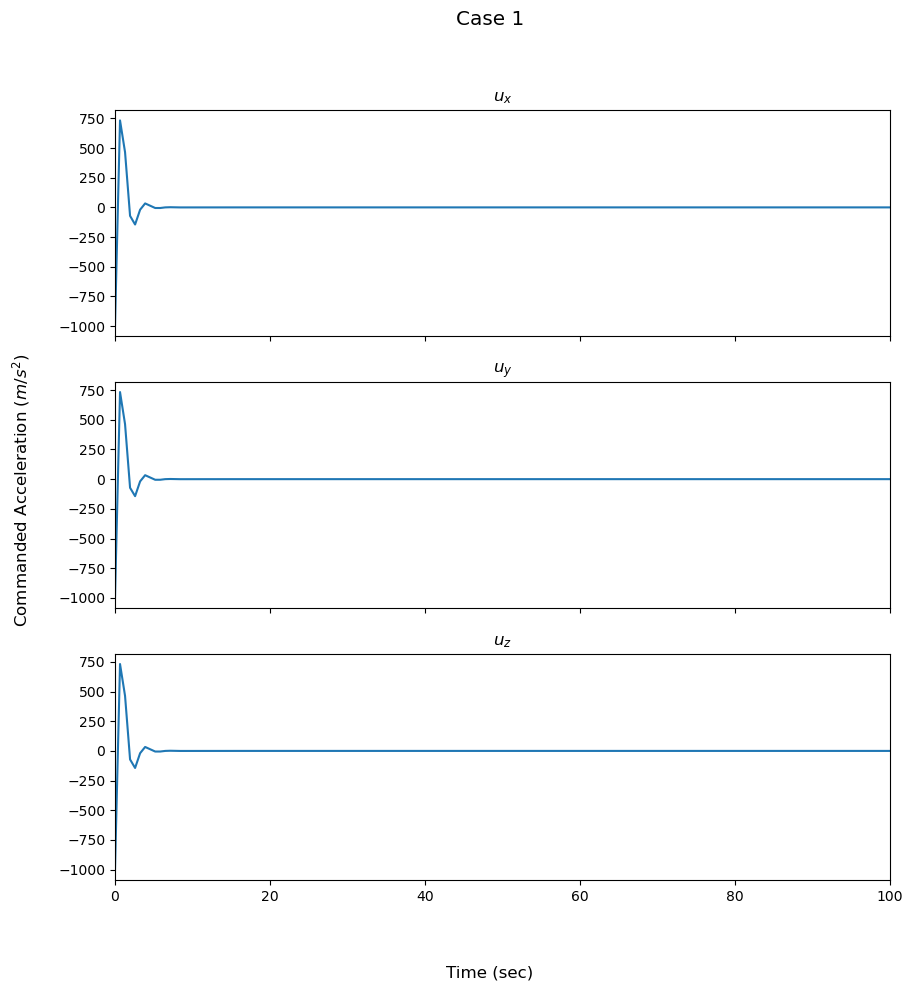

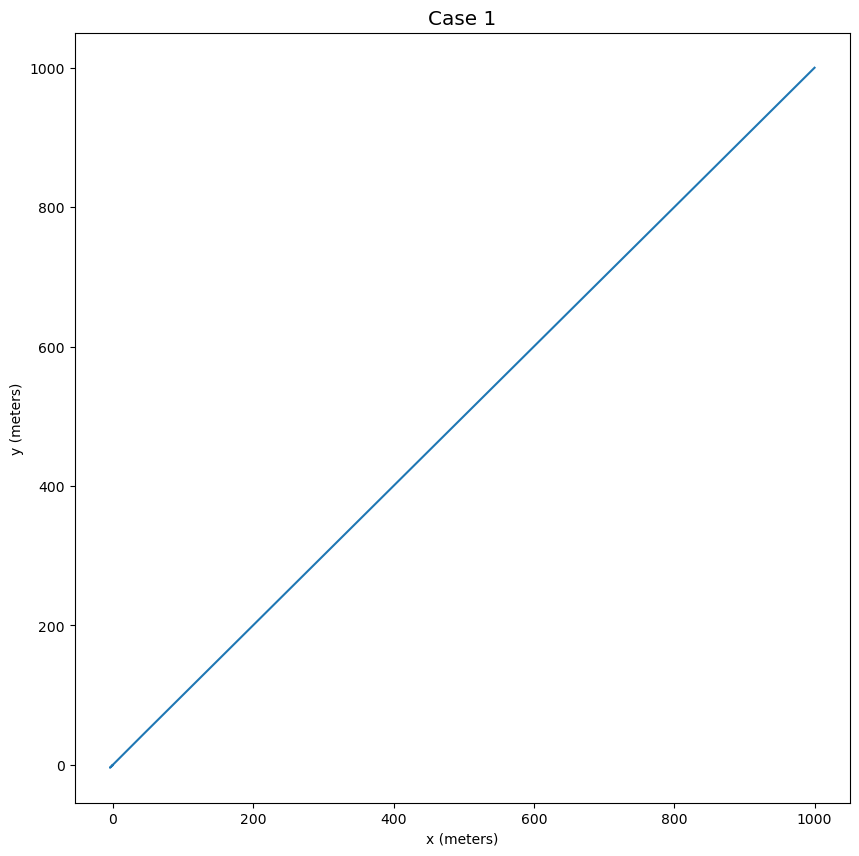

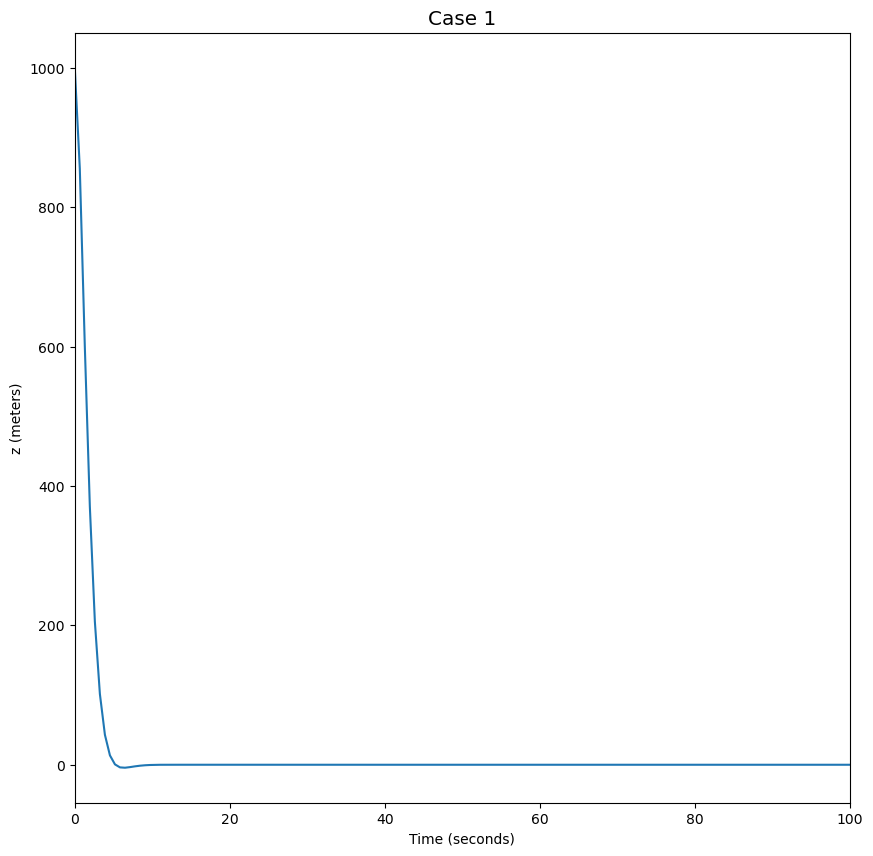

In [16]:
# Plots - Case 1
plot_u(u_case1_care, title="Case 1")
plot_xy(sol_case1_care, title="Case 1")
plot_z(t_eval, sol_case1_care, title="Case 1")

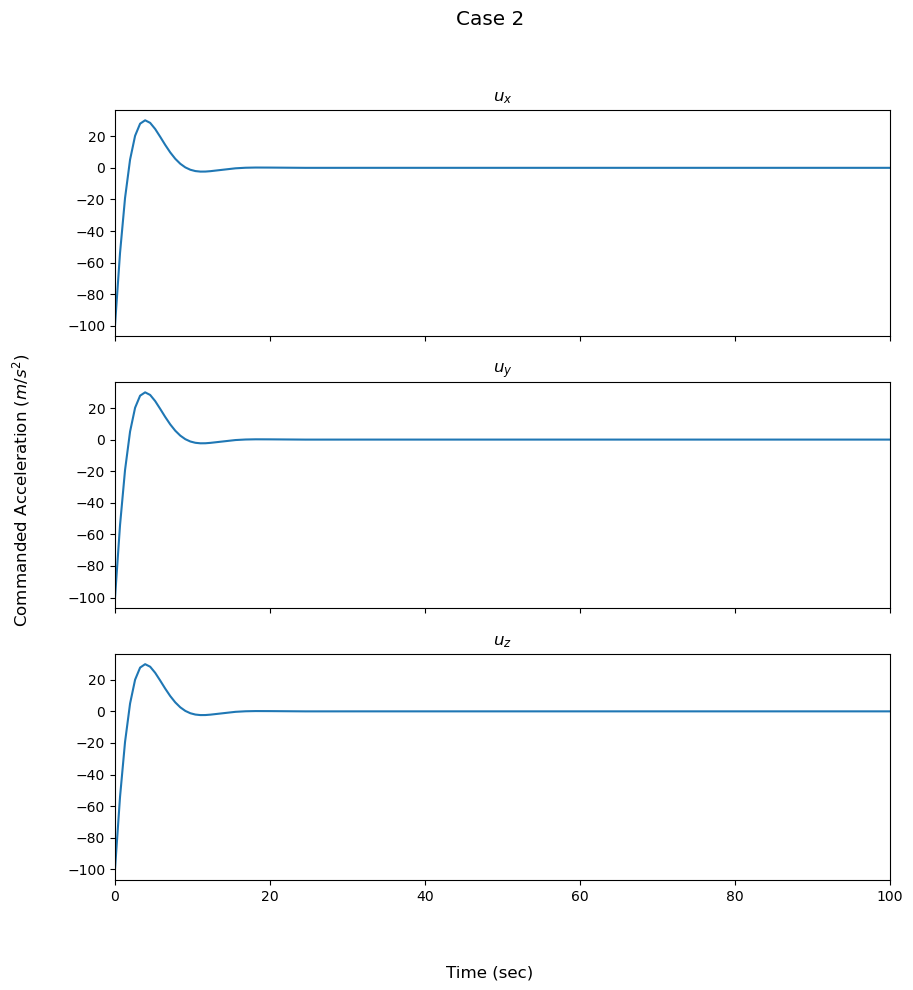

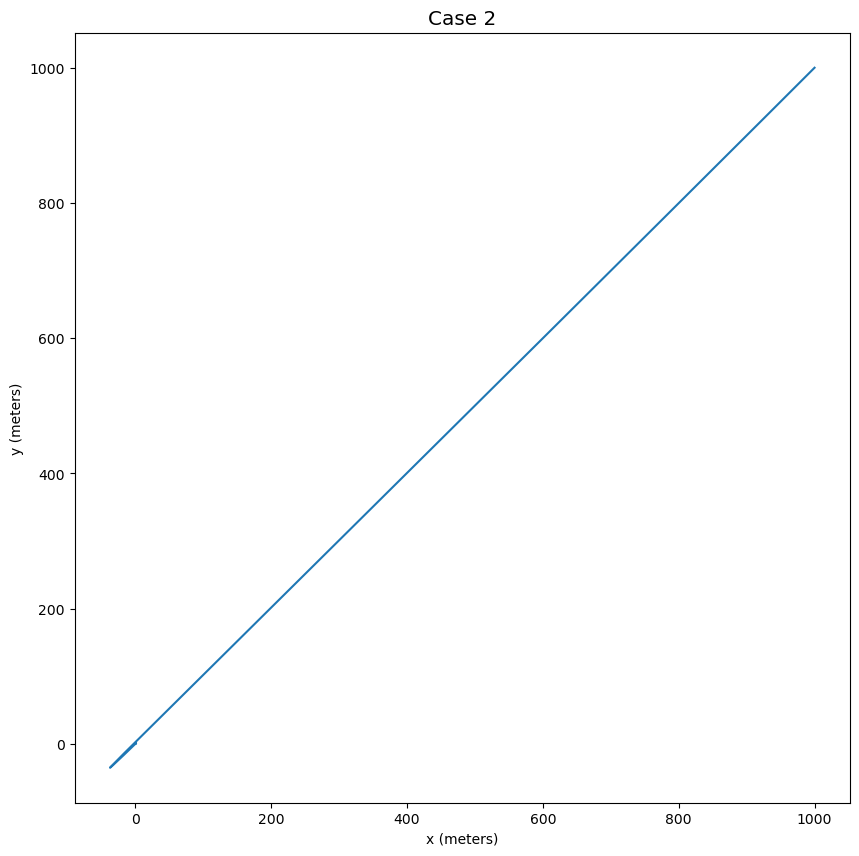

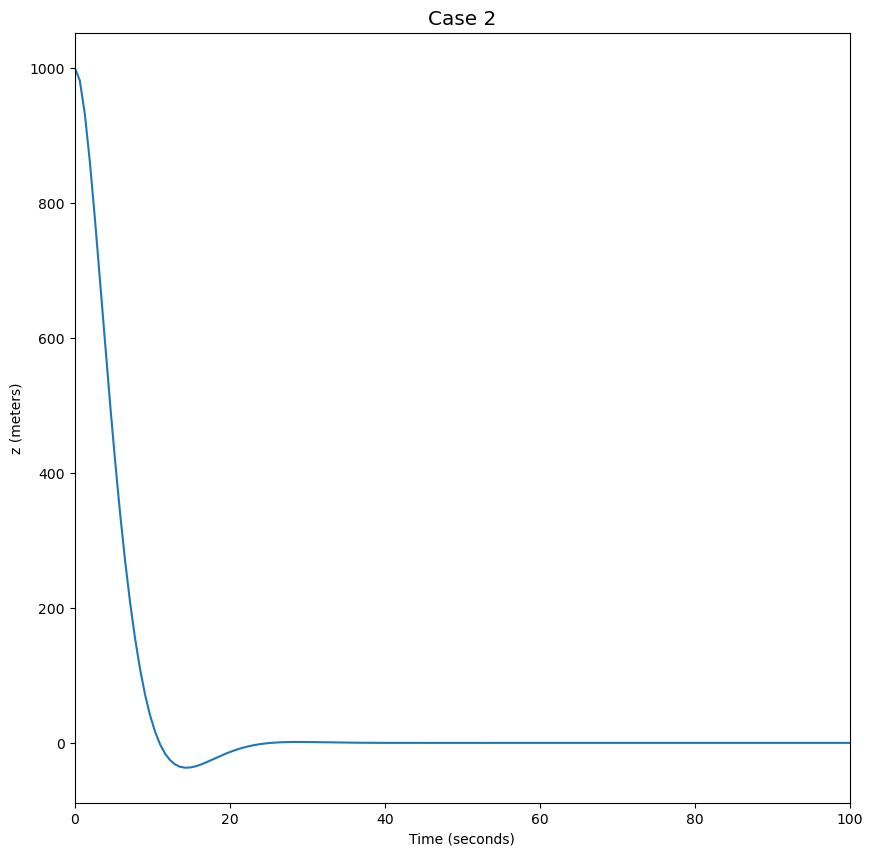

In [17]:
# Plots - Case 2
plot_u(u_case2_care, title="Case 2")
plot_xy(sol_case2_care, title="Case 2")
plot_z(t_eval, sol_case2_care, title="Case 2")

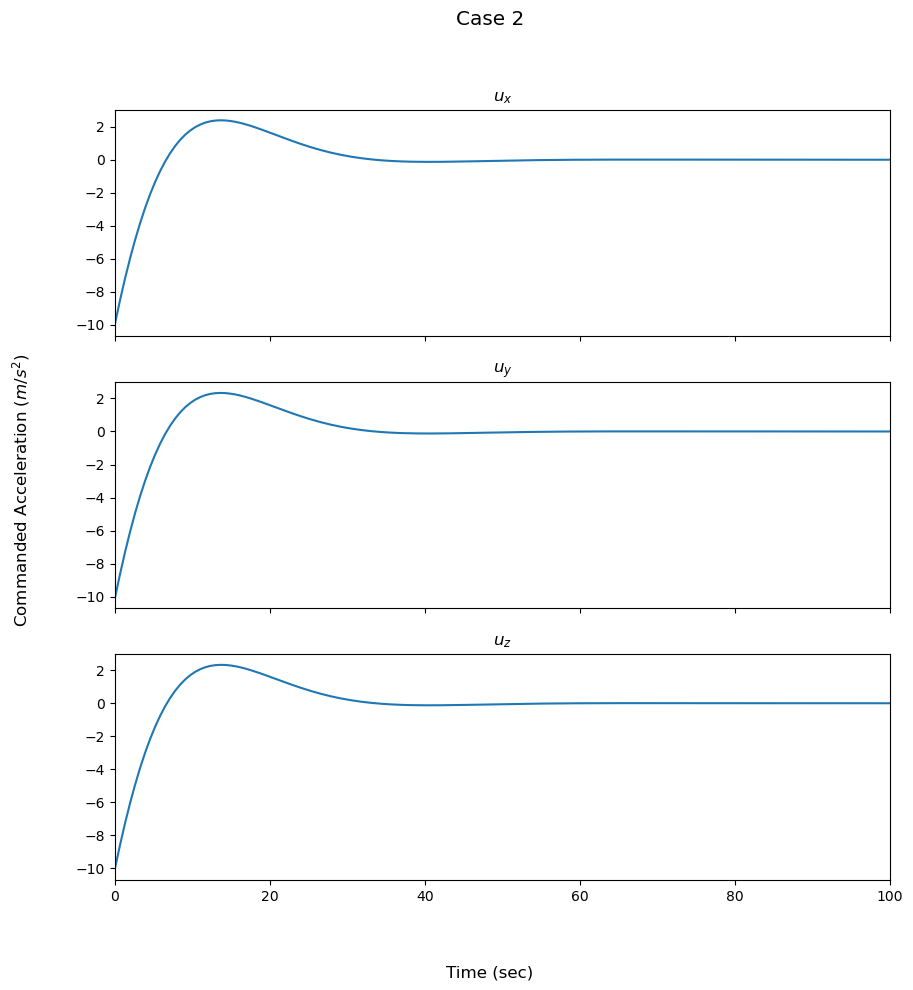

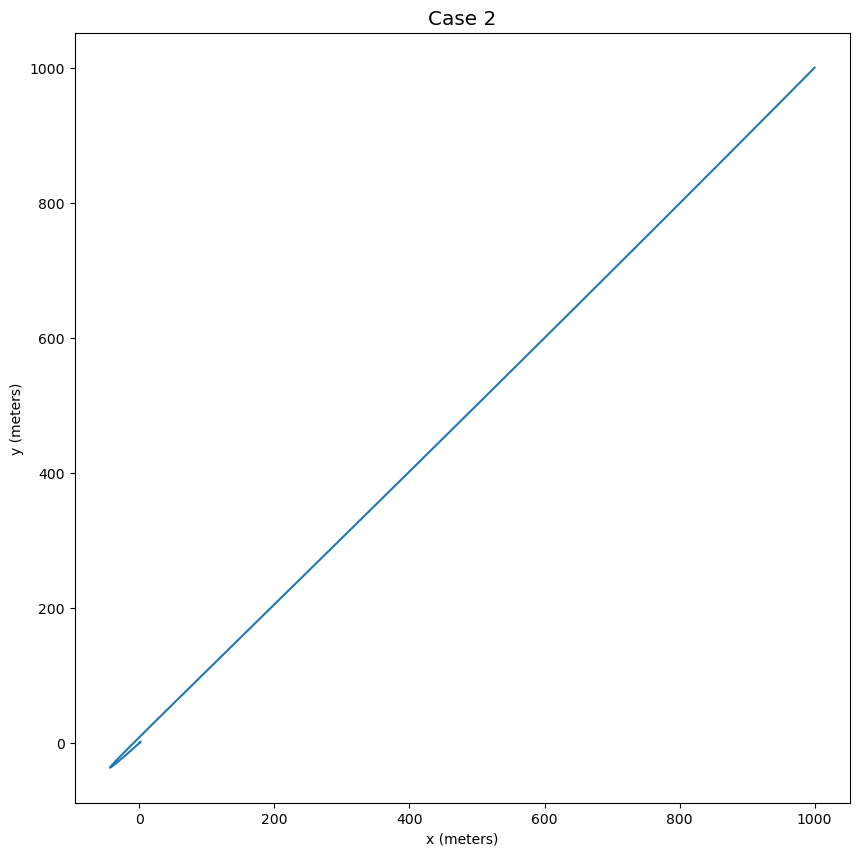

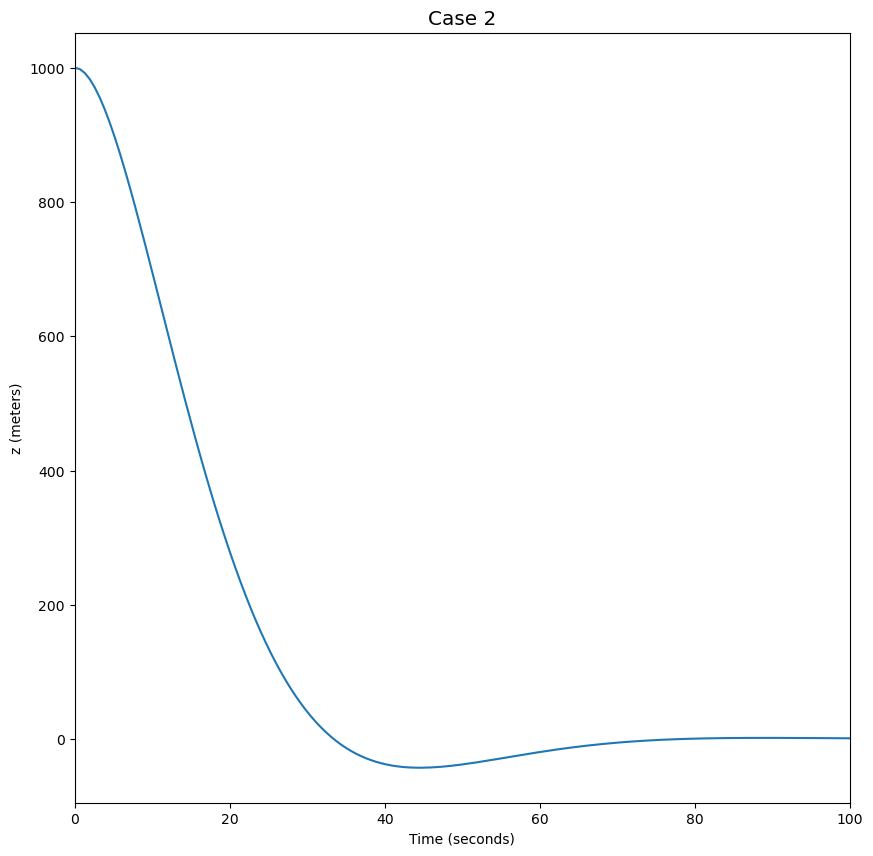

In [18]:
# Plots - Case 3
plot_u(u_case3_care, title="Case 2")
plot_xy(sol_case3_care, title="Case 2")
plot_z(t_eval, sol_case3_care, title="Case 2")

### Problem 5

Design a finite-horizon LQR for the discrete-time LTI system approximation with $\Delta t = 1s$ and $N = 1500$.

In [19]:
# Define dynamics and constants
P0 = np.zeros((6, 6))
N = 1500
dt = 1
F = lambda nt, dt: np.array(
    [
        [
            4 - 3 * cos(nt * dt),
            0,
            0,
            nt ** (-1) * sin(nt * dt),
            2 * nt ** (-1) * (1 - cos(nt * dt)),
            0,
        ],
        [
            6 * (sin(nt * dt) - nt * dt),
            1,
            0,
            -2 * nt ** (-1) * (1 - cos(nt * dt)),
            nt ** (-1) * (4 * sin(nt * dt) - 3 * nt * dt),
            0,
        ],
        [0, 0, cos(nt * dt), 0, 0, nt ** (-1) * sin(nt * dt)],
        [3 * nt * sin(nt * dt), 0, 0, cos(nt * dt), 2 * sin(nt * dt), 0],
        [
            -6 * nt * (1 - cos(nt * dt)),
            0,
            0,
            -2 * sin(nt * dt),
            4 * cos(nt * dt) - 3,
            0,
        ],
        [0, 0, -nt * sin(dt * dt), 0, 0, cos(nt * dt)],
    ]
)
G = lambda nt, dt: F(nt, dt)[:, 3:]

In [20]:
# Define functions to solve discrete-time Riccati Equation and Closed Loop Dynamics


def recursive_solve_are(N, dt, nt, F, G, Q, R, P0):
    F_k = F(nt, dt)
    G_k = G(nt, dt)
    Ps = np.zeros((6, 6, N))

    for k in range(N):
        if k == 0:
            P = P0
            Ps[:, :, k] = P
            continue
        else:
            Pkm1 = (
                F_k.T @ P @ F_k
                + Q
                - (F_k.T @ P @ G_k)
                @ np.linalg.inv(G_k.T @ P @ G_k + R)
                @ (G_k.T @ P @ F_k)
            )
            Ps[:, :, k] = Pkm1
            P = Pkm1
    return Ps


def solve_recursive_cl(N, dt, nt, F, G, Ps, Q, R, x0):
    F_k = F(nt, dt)
    G_k = G(nt, dt)
    xd = np.zeros((6, N))
    u_s = np.zeros((3, N))
    for k in range(N):
        if k == 0:
            x = x0
            xkp1 = x0
            K = np.linalg.inv((G_k.T @ Ps[:, :, 0] @ G_k + R)) @ (
                G_k.T @ Ps[:, :, 0] @ F_k
            )
            u = -K @ x
        elif k < N - 1:
            K = np.linalg.inv((G_k.T @ Ps[:, :, k + 1] @ G_k + R)) @ (
                G_k.T @ Ps[:, :, k + 1] @ F_k
            )
            u = -K @ x
            xkp1 = (F_k - G_k @ K) @ x
        else:
            K = np.linalg.inv((G_k.T @ Ps[:, :, k] @ G_k + R)) @ (
                G_k.T @ Ps[:, :, k] @ F_k
            )
            u = -K @ x
            xkp1 = (F_k - G_k @ K) @ x
        xd[:, k] = xkp1
        u_s[:, k] = u
        x = xkp1
    return xd, u_s

In [21]:
discrete_times = np.linspace(0, N * dt, N)
# Case 1
Q = np.eye(6)
R = np.eye(3)

P_case1_discrete = recursive_solve_are(N, dt, nt, F, G, Q, R, P0)
sol_case1_discrete, u_case1_discrete = solve_recursive_cl(
    N, dt, nt, F, G, P_case1_discrete, Q, R, x0
)

# Case 2
Q = np.eye(6)
R = 100 * np.eye(3)

P_case2_discrete = recursive_solve_are(N, dt, nt, F, G, Q, R, P0)
sol_case2_discrete, u_case2_discrete = solve_recursive_cl(
    N, dt, nt, F, G, P_case2_discrete, Q, R, x0
)

# Case 3
Q = np.eye(6)
R = 10000 * np.eye(3)

P_case3_discrete = recursive_solve_are(N, dt, nt, F, G, Q, R, P0)
sol_case3_discrete, u_case3_discrete = solve_recursive_cl(
    N, dt, nt, F, G, P_case3_discrete, Q, R, x0
)

(0.0, 100.0)

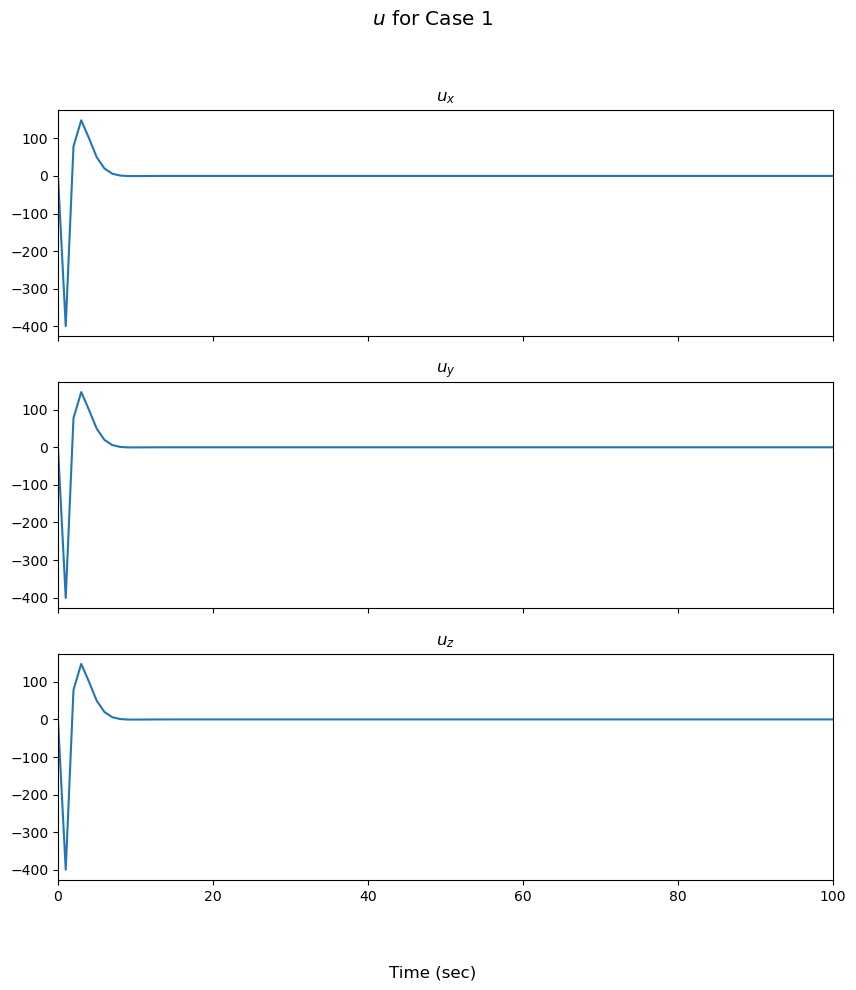

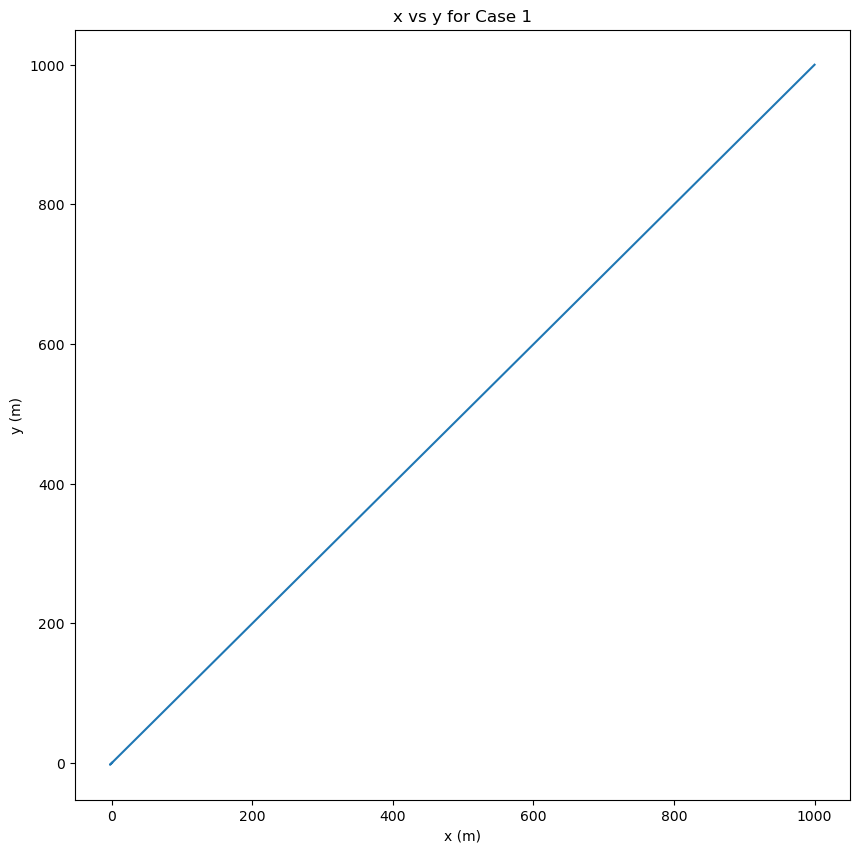

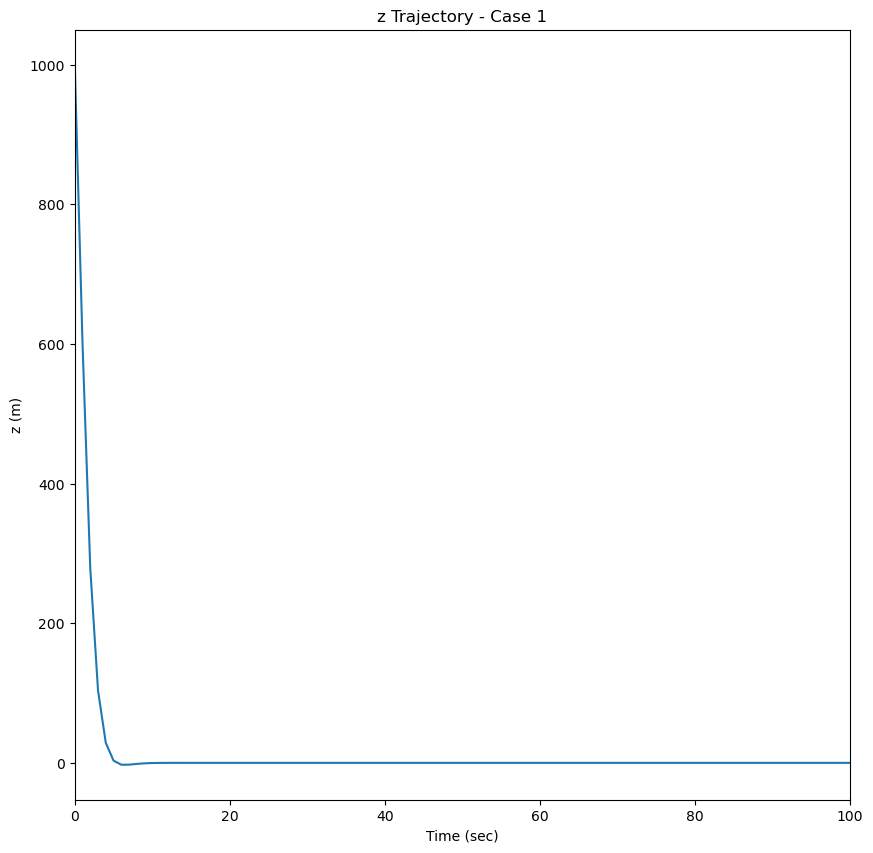

In [22]:
# Plots - Case 1

# u
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10), sharex=True)
fig.suptitle("$u$ for Case 1", fontsize="x-large")
for k in range(3):
    axes[k].plot(discrete_times, u_case1_discrete[k, :])
    axes[k].set_xlim([0, 100])
    if k == 0:
        axes[k].set_title("$u_x$")
    if k == 1:
        axes[k].set_title("$u_y$")
    if k == 2:
        axes[k].set_title("$u_z$")
fig.supxlabel("Time (sec)")

# x vs y
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(sol_case1_discrete[0, :], sol_case1_discrete[1, :])
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_title("x vs y for Case 1")

# z
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(sol_case1_discrete[2, :])
ax.set_xlabel("Time (sec)")
ax.set_ylabel("z (m)")
ax.set_title("z Trajectory - Case 1")
ax.set_xlim([0, 100])

(0.0, 100.0)

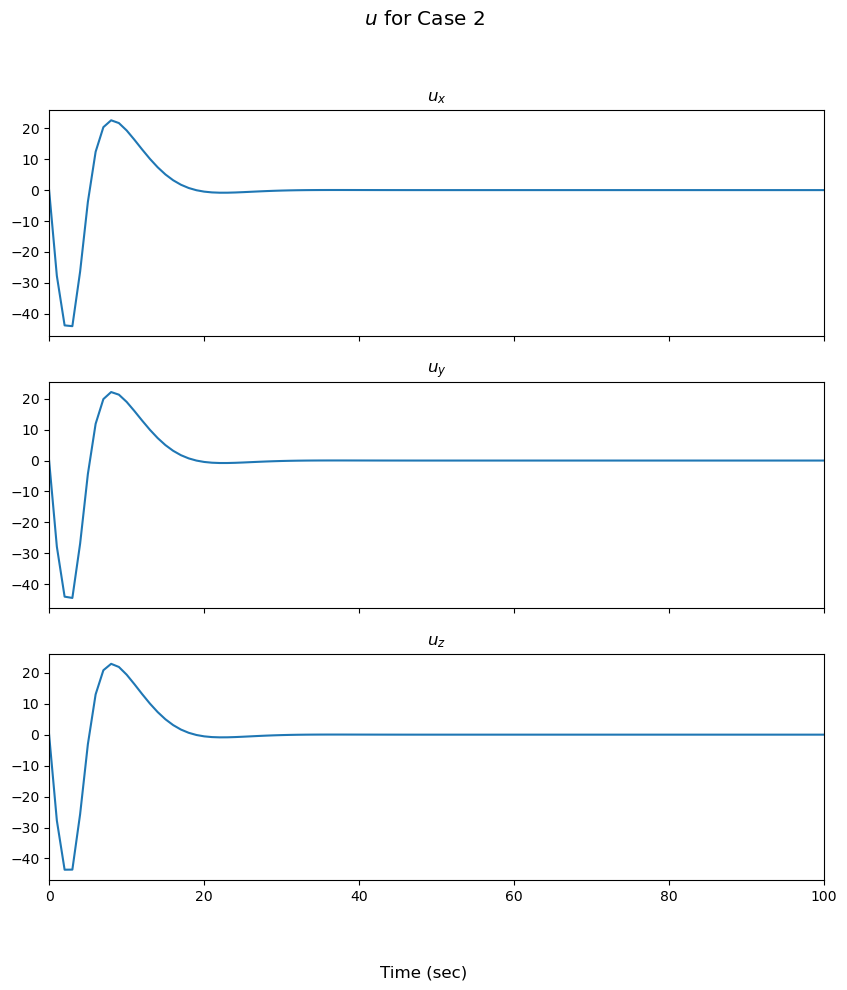

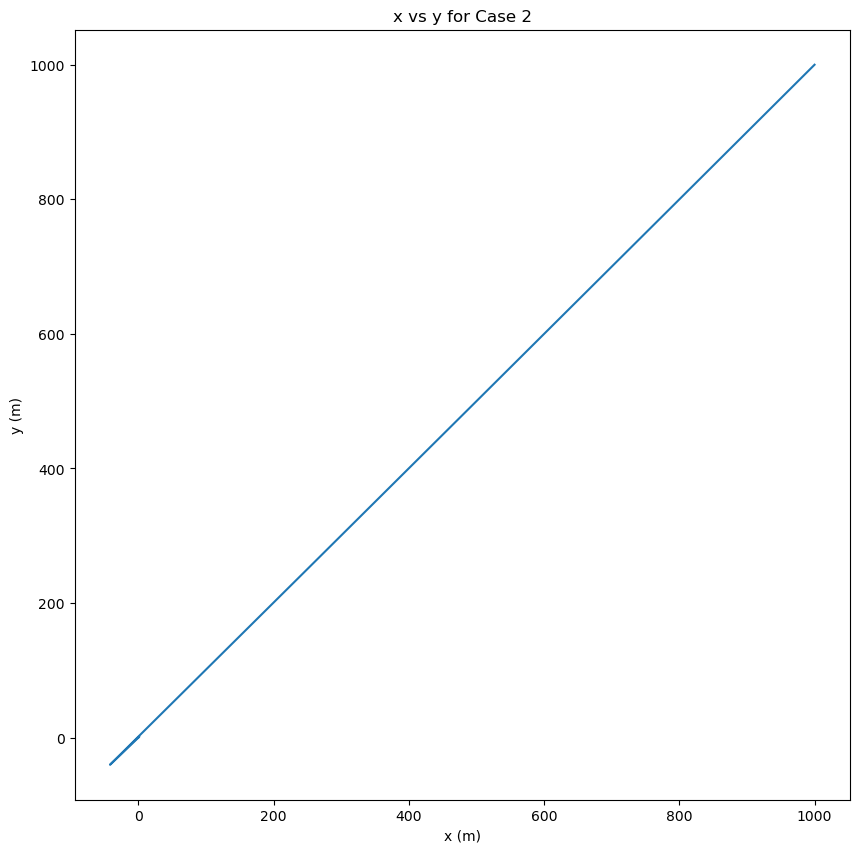

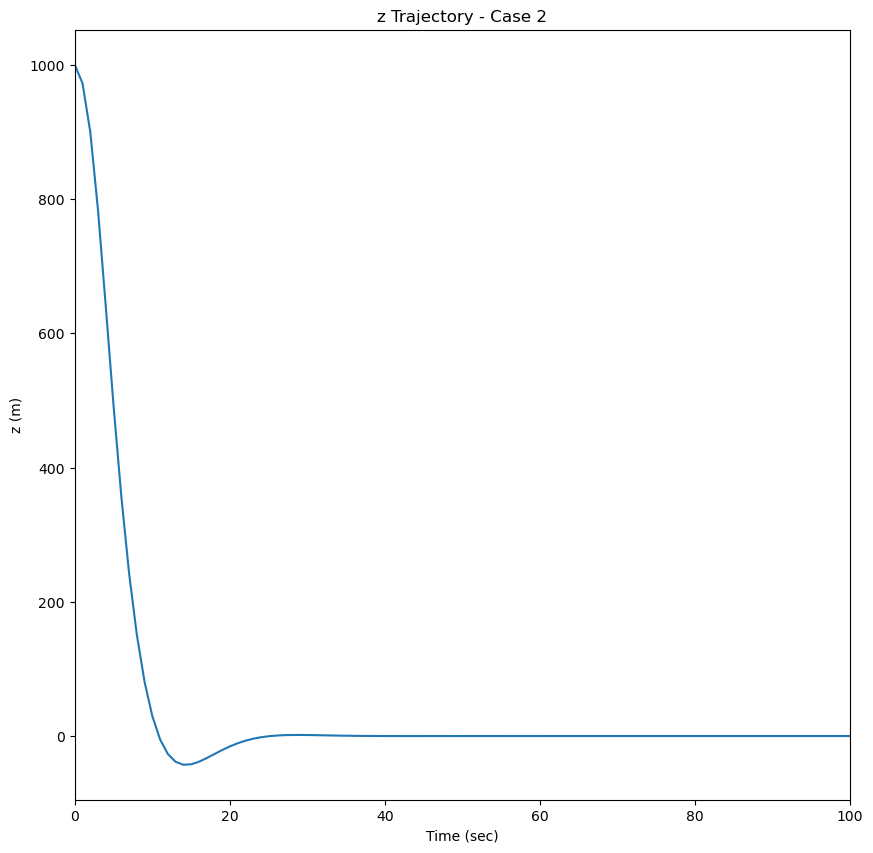

In [23]:
# Plots - Case 2

# u
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10), sharex=True)
fig.suptitle("$u$ for Case 2", fontsize="x-large")
for k in range(3):
    axes[k].plot(discrete_times, u_case2_discrete[k, :])
    axes[k].set_xlim([0, 100])
    if k == 0:
        axes[k].set_title("$u_x$")
    if k == 1:
        axes[k].set_title("$u_y$")
    if k == 2:
        axes[k].set_title("$u_z$")
fig.supxlabel("Time (sec)")

# x vs y
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(sol_case2_discrete[0, :], sol_case2_discrete[1, :])
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_title("x vs y for Case 2")

# z
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(sol_case2_discrete[2, :])
ax.set_xlabel("Time (sec)")
ax.set_ylabel("z (m)")
ax.set_title("z Trajectory - Case 2")
ax.set_xlim([0, 100])

(0.0, 100.0)

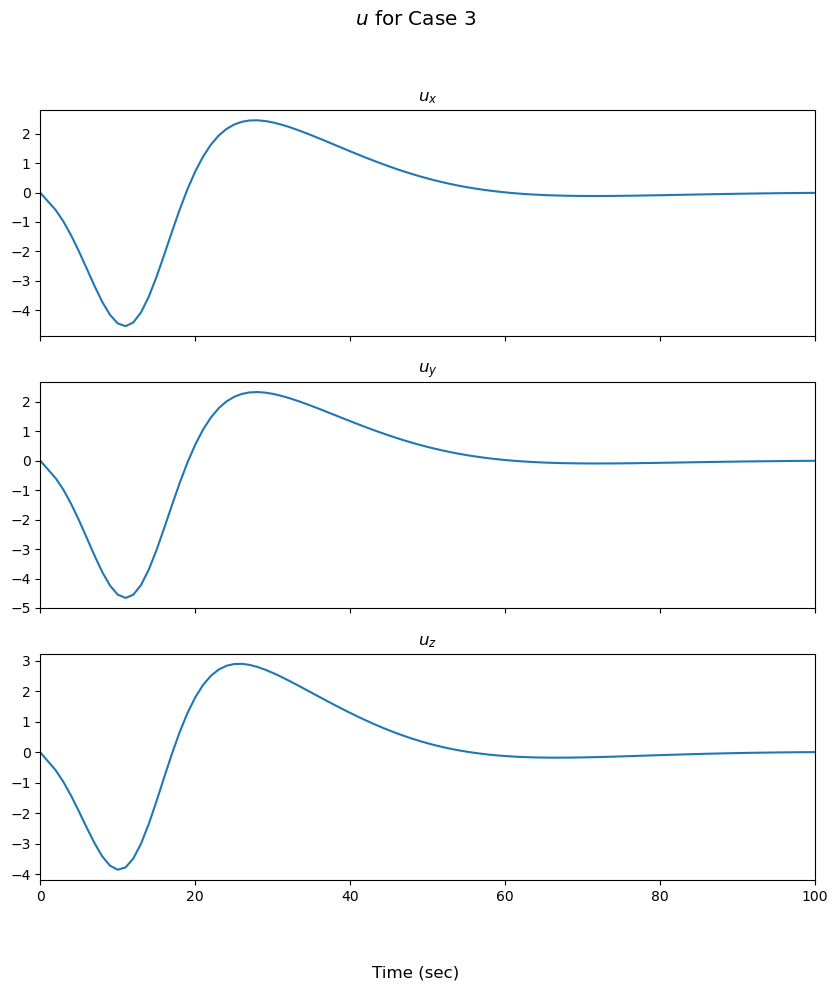

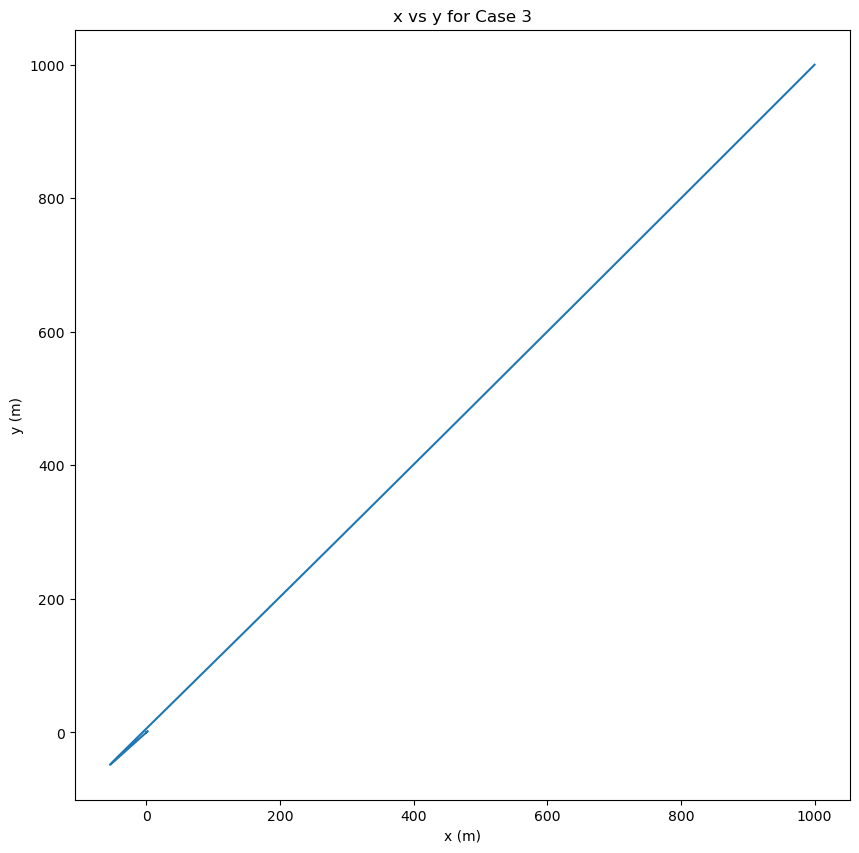

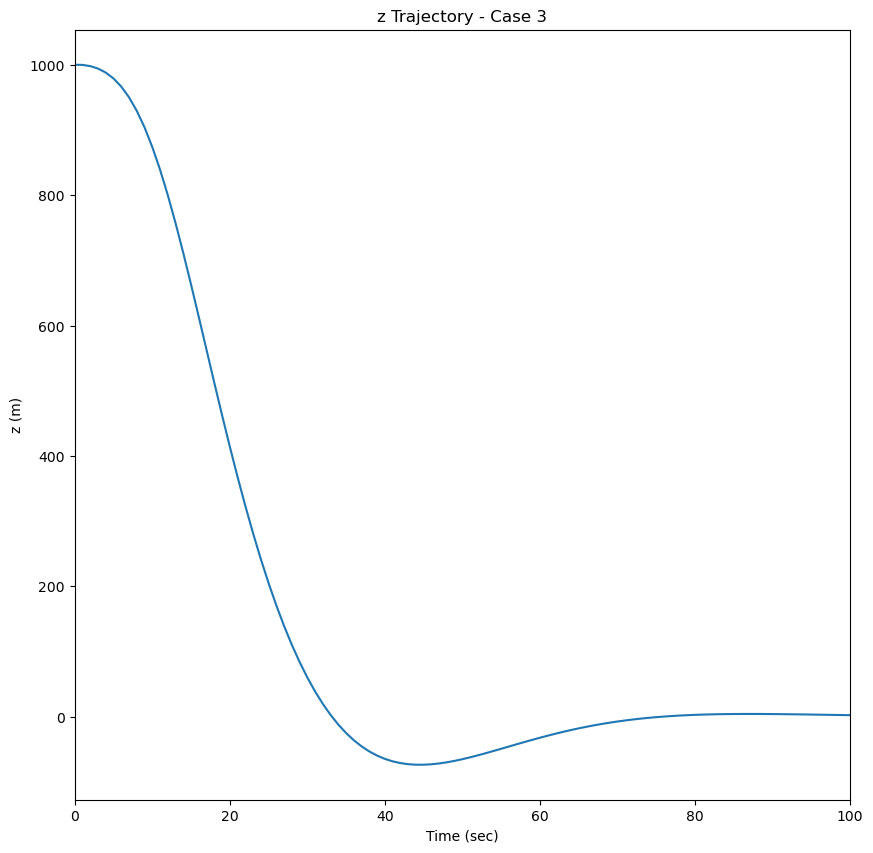

In [24]:
# Plots - Case 3

# u
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10), sharex=True)
fig.suptitle("$u$ for Case 3", fontsize="x-large")
for k in range(3):
    axes[k].plot(discrete_times, u_case3_discrete[k, :])
    axes[k].set_xlim([0, 100])
    if k == 0:
        axes[k].set_title("$u_x$")
    if k == 1:
        axes[k].set_title("$u_y$")
    if k == 2:
        axes[k].set_title("$u_z$")
fig.supxlabel("Time (sec)")

# x vs y
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(sol_case3_discrete[0, :], sol_case3_discrete[1, :])
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_title("x vs y for Case 3")

# z
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(sol_case3_discrete[2, :])
ax.set_xlabel("Time (sec)")
ax.set_ylabel("z (m)")
ax.set_title("z Trajectory - Case 3")
ax.set_xlim([0, 100])

### Problem 6

In [25]:
def solve_recursive_cl_constant_P(N, dt, nt, F, G, P, Q, R, x0):
    F_k = F(nt, dt)
    G_k = G(nt, dt)
    K_k = np.linalg.inv(G_k.T @ P @ G_k + R) @ G_k.T @ P @ F_k

    xd = np.zeros((6, N))
    u_s = np.zeros((3, N))

    for k in range(N):
        if k == 0:
            x = x0
            xd[:, k] = x
            u_s[:, k] = -K_k @ x
        else:
            xkp1 = (F_k - G_k @ K_k) @ x
            u = -K_k @ x
            xd[:, k] = xkp1
            u_s[:, k] = u
            x = xkp1
    return xd, u_s

In [26]:
# Case 1
Q = np.eye(6)
R = np.eye(3)
P_dare_case1 = sp.linalg.solve_discrete_are(F(nt, dt), G(nt, dt), Q, R)
sol_dare_case1, u_dare_case1 = solve_recursive_cl_constant_P(
    N, dt, nt, F, G, P_dare_case1, Q, R, x0
)

# Case 2
Q = np.eye(6)
R = 100 * np.eye(3)
P_dare_case2 = sp.linalg.solve_discrete_are(F(nt, dt), G(nt, dt), Q, R)
sol_dare_case2, u_dare_case2 = solve_recursive_cl_constant_P(
    N, dt, nt, F, G, P_dare_case2, Q, R, x0
)

# Case 3
Q = np.eye(6)
R = 10000 * np.eye(3)
P_dare_case3 = sp.linalg.solve_discrete_are(F(nt, dt), G(nt, dt), Q, R)
sol_dare_case3, u_dare_case3 = solve_recursive_cl_constant_P(
    N, dt, nt, F, G, P_dare_case3, Q, R, x0
)

(0.0, 100.0)

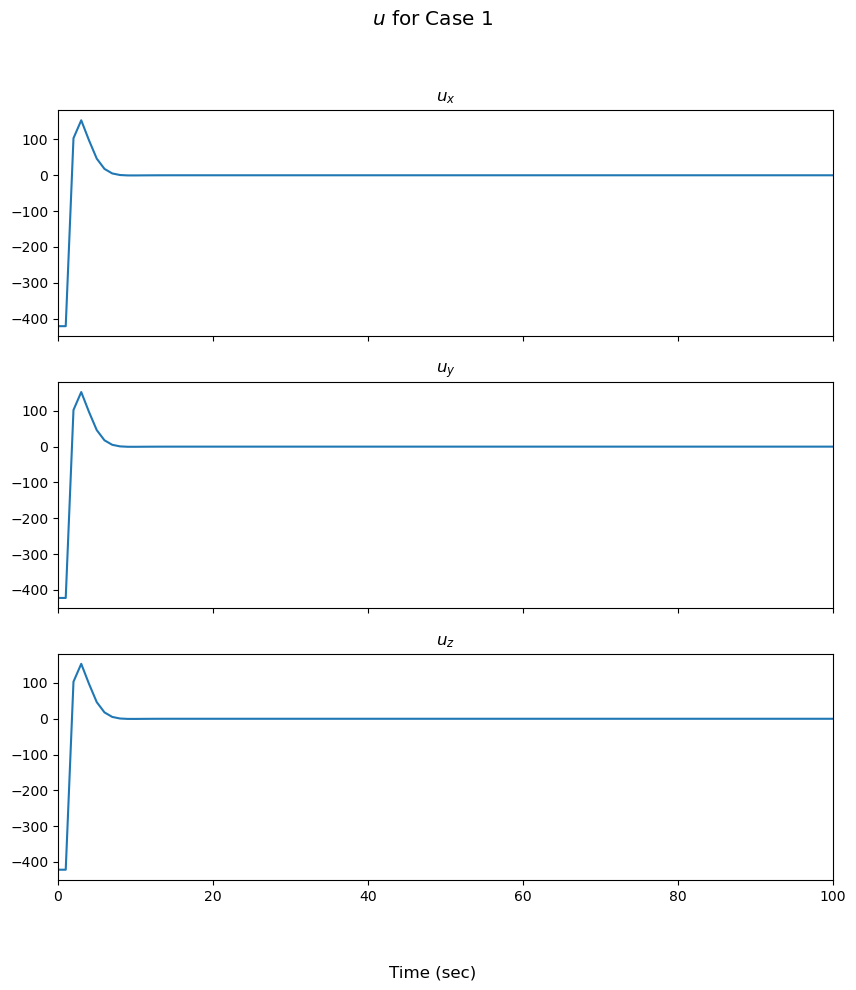

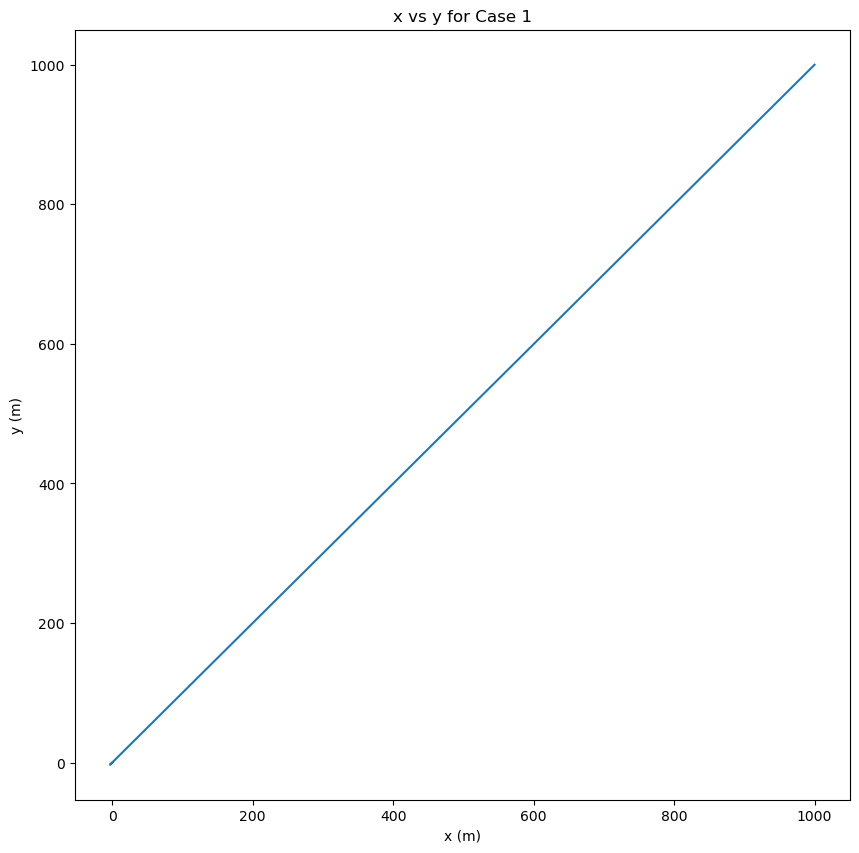

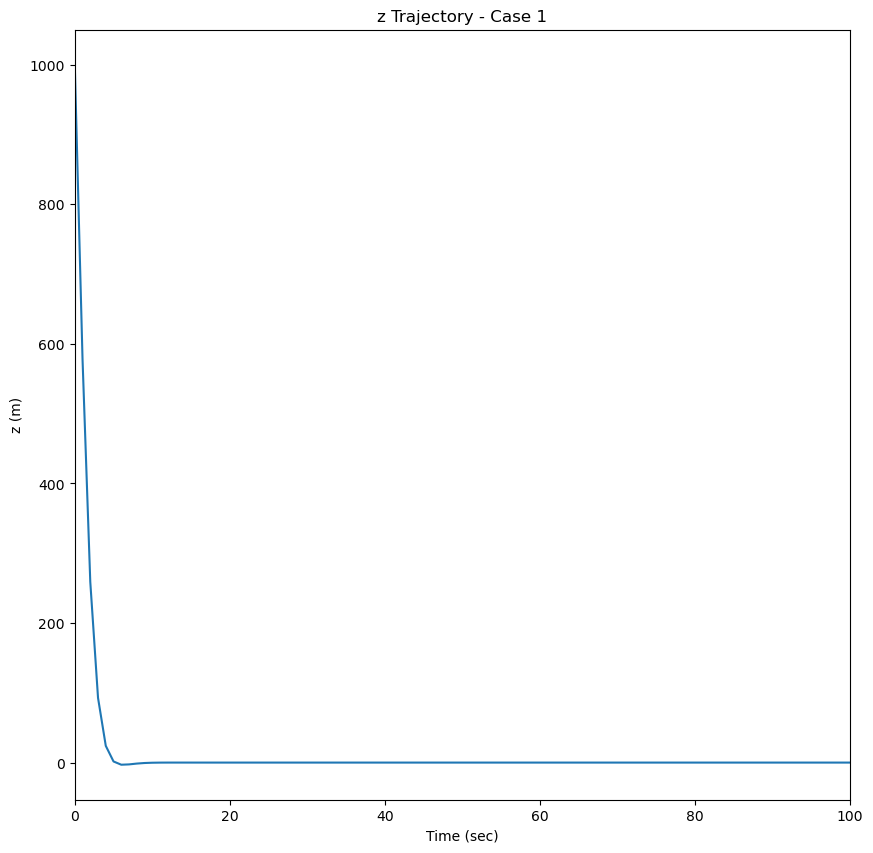

In [27]:
# u
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10), sharex=True)
fig.suptitle("$u$ for Case 1", fontsize="x-large")
for k in range(3):
    axes[k].plot(discrete_times, u_dare_case1[k, :])
    axes[k].set_xlim([0, 100])
    if k == 0:
        axes[k].set_title("$u_x$")
    if k == 1:
        axes[k].set_title("$u_y$")
    if k == 2:
        axes[k].set_title("$u_z$")
fig.supxlabel("Time (sec)")

# x vs y
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(sol_dare_case1[0, :], sol_dare_case1[1, :])
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_title("x vs y for Case 1")

# z
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(sol_dare_case1[2, :])
ax.set_xlabel("Time (sec)")
ax.set_ylabel("z (m)")
ax.set_title("z Trajectory - Case 1")
ax.set_xlim([0, 100])

(0.0, 100.0)

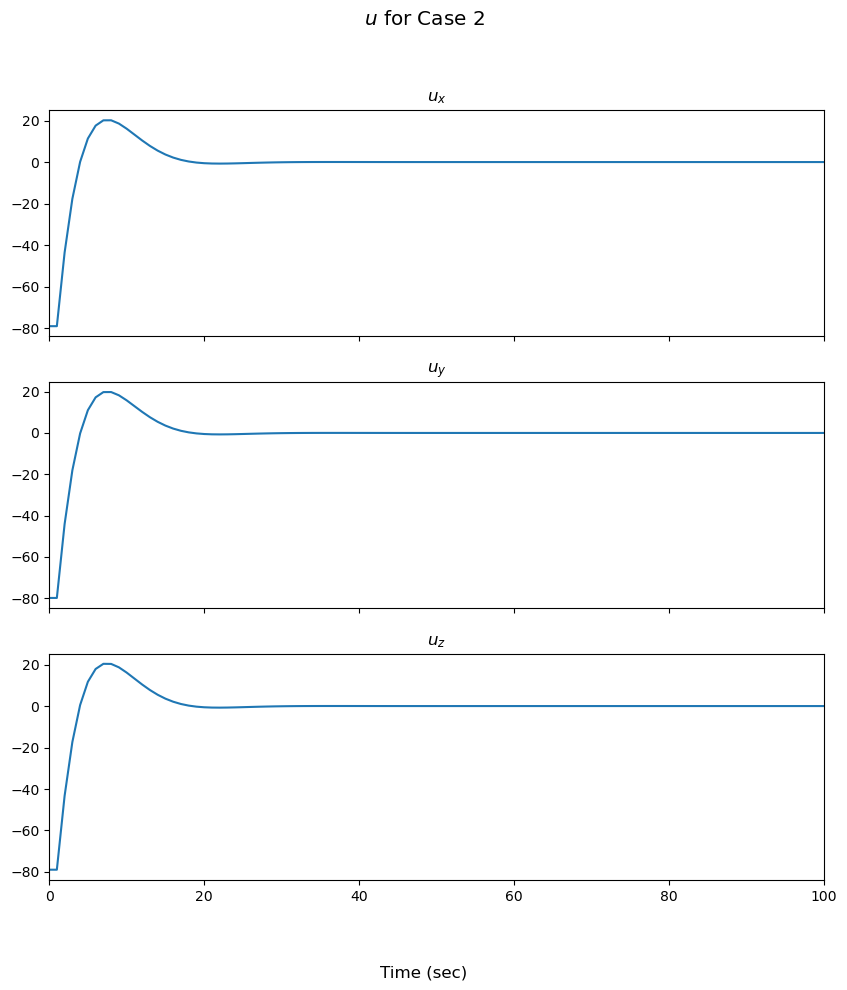

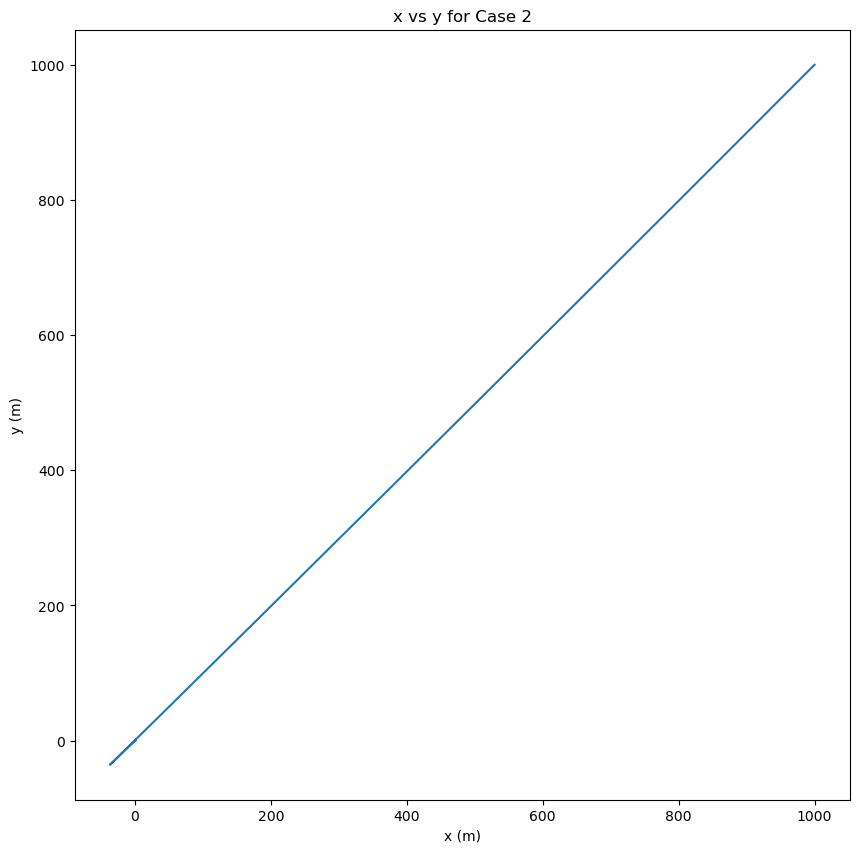

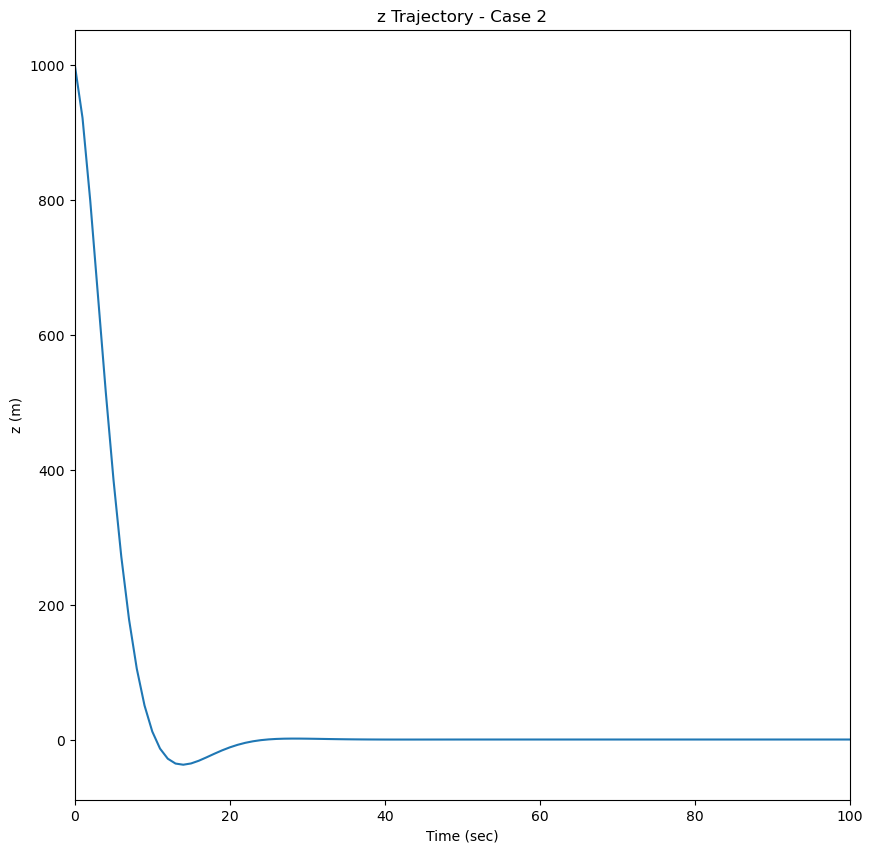

In [28]:
# u
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10), sharex=True)
fig.suptitle("$u$ for Case 2", fontsize="x-large")
for k in range(3):
    axes[k].plot(discrete_times, u_dare_case2[k, :])
    axes[k].set_xlim([0, 100])
    if k == 0:
        axes[k].set_title("$u_x$")
    if k == 1:
        axes[k].set_title("$u_y$")
    if k == 2:
        axes[k].set_title("$u_z$")
fig.supxlabel("Time (sec)")

# x vs y
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(sol_dare_case2[0, :], sol_dare_case2[1, :])
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_title("x vs y for Case 2")

# z
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(sol_dare_case2[2, :])
ax.set_xlabel("Time (sec)")
ax.set_ylabel("z (m)")
ax.set_title("z Trajectory - Case 2")
ax.set_xlim([0, 100])

(0.0, 100.0)

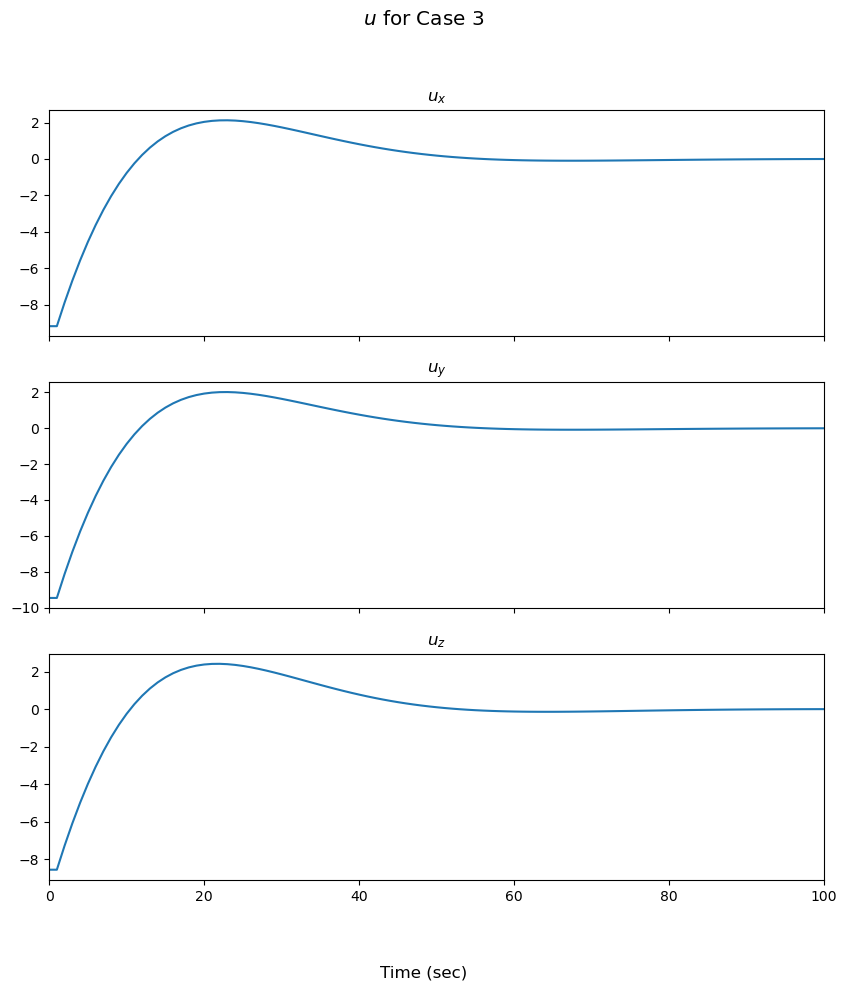

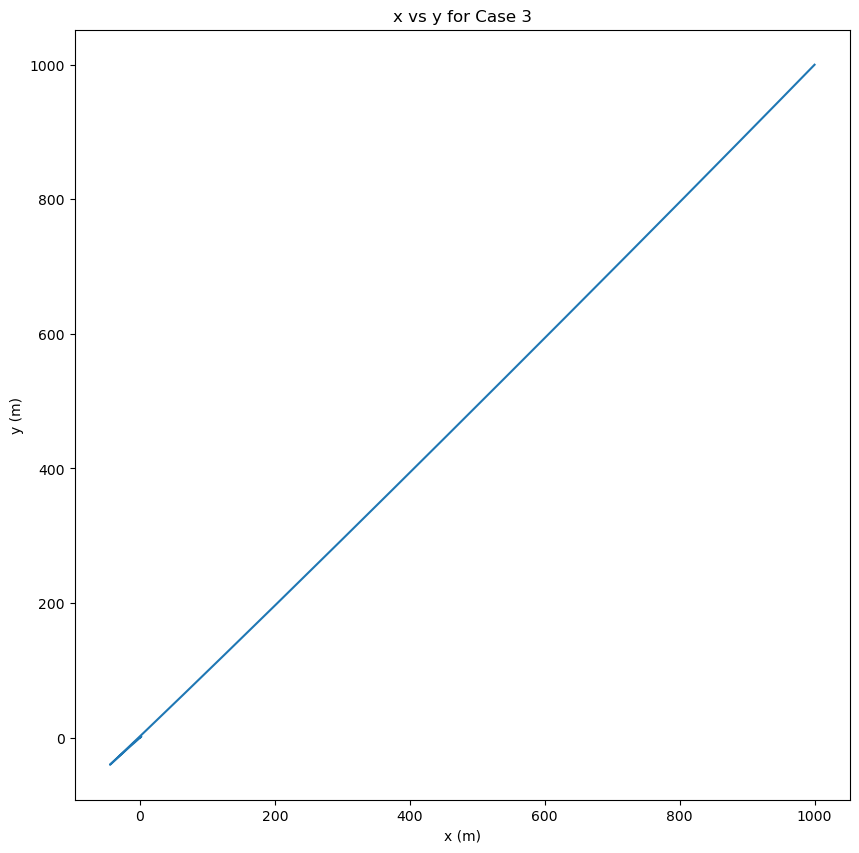

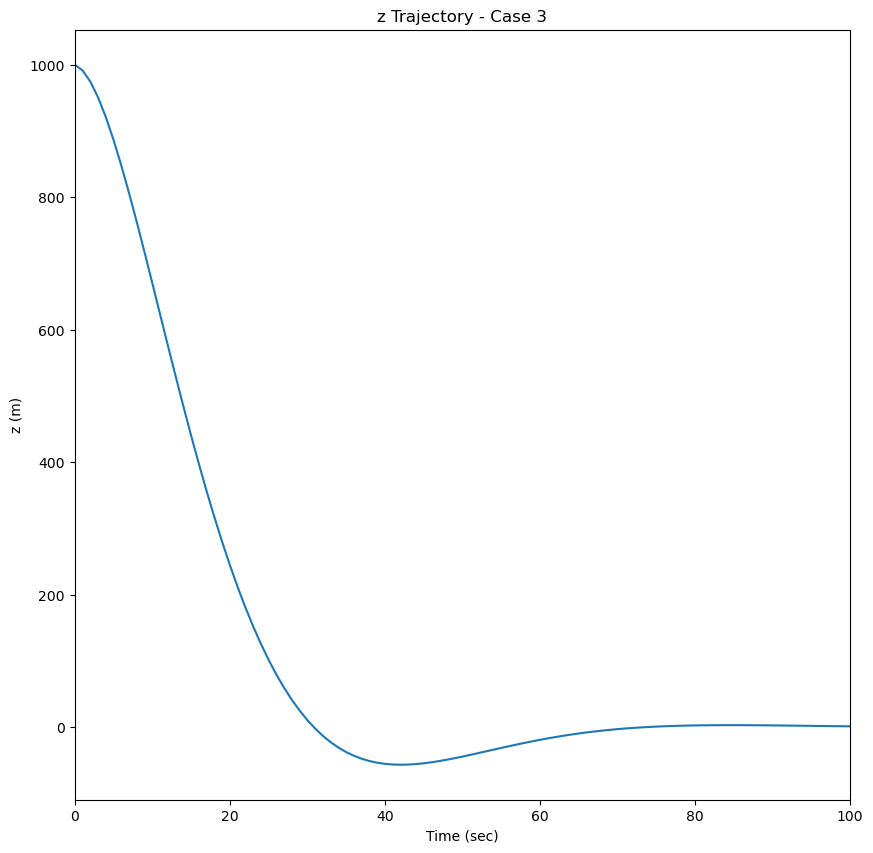

In [29]:
# u
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10), sharex=True)
fig.suptitle("$u$ for Case 3", fontsize="x-large")
for k in range(3):
    axes[k].plot(discrete_times, u_dare_case3[k, :])
    axes[k].set_xlim([0, 100])
    if k == 0:
        axes[k].set_title("$u_x$")
    if k == 1:
        axes[k].set_title("$u_y$")
    if k == 2:
        axes[k].set_title("$u_z$")
fig.supxlabel("Time (sec)")

# x vs y
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(sol_dare_case3[0, :], sol_dare_case3[1, :])
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_title("x vs y for Case 3")

# z
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(sol_dare_case3[2, :])
ax.set_xlabel("Time (sec)")
ax.set_ylabel("z (m)")
ax.set_title("z Trajectory - Case 3")
ax.set_xlim([0, 100])

## Problem 7
Comment on all designs and the differences between them.

1. Finite Horizon vs. Infinite Horizon LQR - Continuous
> Finite horizon LQR seemed to have larger variance in commands compared to Infinite horizon LQR for the contunous time system. Also, the oscillations in the dynamics for a given Q, R in the finite horizon LQR appeared to be larger than those for the infinite horizon LQR.<br><br> Additionally, the z-response appears to be much less 'refined' with the finite horizon LQR as compared to the infinite horizon LQR.

2. Finite Horizon vs. Infinite Horizon LQR - Discrete
> For cases 2 and 3, the finite horizon LQR appeared to command more than the infinite horizon LQR. Thus, in the finite horizon LQR, there was overshoot in the commands. The response of the system, however, remained approximately the same between the finite horizon and infinite horizon LQR controllers. 